In [99]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import math
import seaborn as sns
import ast
from collections import Counter
import networkx as nx

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm

# src imports
from src.utils import cleaning
#from src.utils import tokenization
from src.utils import filling
from src.utils import cluster_search
from src.data.continents_clusters import regions

# Data loading

In [100]:
# data path
DATA = './data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries loading
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset loading
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

# ratings datasets loading
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')
df_ratings_imdb = pd.read_csv(DATA + 'title.ratings.tsv', sep='\t')

For now, the plots dataset `df_plots` does not require any cleaning operation, as the dataset presents 0% missing values in its columns with no particular format to standardize. However, the movies and characters dataset do require significant cleaning, as is presented below.

# Movies dataset wrangling

Duplicate movies exist in the movies dataset and are first considered.

In [101]:
# df_movies has duplicates of the same movies based on their title which we will delete, only 5% of all data
df_movies = df_movies.drop_duplicates(subset=['title'])

In [102]:
# the df_tmdb dataframe has many duplicates for titles but these could be movies with the same title that are different or movies that are the same
# but are different in features on these movies
df_tmdb = df_tmdb.drop_duplicates(subset=['imdb_id'])

In [103]:
# Altering the release date feature in the TMDB dataframe and in the moves dataframe to match, for unique index creation

# drop movies in each dataframe with missing release dates 
df_movies = df_movies.dropna(subset=['release_date'])
df_tmdb = df_tmdb.dropna(subset=['release_date'])
df_movies['release_date'] = df_movies['release_date'].apply(cleaning.clean_dates)
df_tmdb['release_date'] = df_tmdb['release_date'].apply(cleaning.clean_dates)

title_release_movies = df_movies.title + df_movies.release_date.astype(str)
df_movies_copy = df_movies.copy()
df_movies_copy.index = title_release_movies

title_release_tmdb = df_tmdb.title + df_tmdb.release_date.astype(str)
df_tmdb_copy = df_tmdb.copy()
df_tmdb_copy.index = title_release_tmdb

df_movies_tmdb = pd.merge(df_movies_copy, df_tmdb_copy, left_index=True, right_index=True)

# as the unique index of title and release date was used to merge the dataframes, the original title columns are duplicated and must be removed
df_movies_tmdb = df_movies_tmdb.drop(['title_y'], axis = 1).rename(columns={'title_x': 'title'}) 

With duplicate movies dropped, the TMDB dataset can be merged as to enrich the movie metadata.

In [104]:
# drop some duplicate columns and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={'spoken_languages_x': 'spoken_languages'}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={'genres_x': 'genres'}) 

In [105]:
# cleaning 'spoken_languages', 'countries', 'genres' df_movies columns in df_movies_tmdb
df_movies_tmdb['spoken_languages'] = df_movies_tmdb['spoken_languages'].apply(cleaning.clean_idxs)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning.clean_idxs)
df_movies_tmdb['genres'] = df_movies_tmdb['genres'].apply(cleaning.clean_idxs)

In [106]:
# use the release date of the TMDB dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb['release_date_x'] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])

# drop missing release dates, remove duplicate column and rename release_date_x
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'release_date_x': "release_date"}) 

# filter dates to meaningful ones by keeping the release interval [1888, 2012], since 
# the very first movie was released in 1888 and meaningful data from df_movies is up to 2012
df_movies_tmdb = cleaning.filter_years(df_movies_tmdb, 'release_date')

In [107]:
# use the revenues of the TMDB dataset to fill the revenues of a movie if not present in CMU dataset
df_movies_tmdb['revenue_x'] = df_movies_tmdb['revenue_x'].fillna(df_movies_tmdb['revenue_y'])

# remove duplicate column and rename revenue_x
df_movies_tmdb = df_movies_tmdb.drop(['revenue_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'revenue_x': "revenue"}) 

In [108]:
# use the runtimes of the TMDB dataset to fill the runtimes of a movie if not present in CMU dataset
df_movies_tmdb['runtime_x'] = df_movies_tmdb['runtime_x'].fillna(df_movies_tmdb['runtime_y'])

# remove duplicate column and rename runtime_x
df_movies_tmdb = df_movies_tmdb.drop(['runtime_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'runtime_x': "runtime"}) 

In [109]:
# remove movies with no genre reported
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

In [110]:
# dropping movies that have missing IMDB IDs
df_movies_tmdb = df_movies_tmdb.dropna(subset=["imdb_id"])
df_movies_tmdb = df_movies_tmdb.drop(df_movies_tmdb[df_movies_tmdb["imdb_id"] == 'nan'].index)

# IMDB references in df_movies_tmdb are formatted differently than in df_ratings_link
df_movies_tmdb['imdb_id'] = df_movies_tmdb['imdb_id'].apply(cleaning.clean_imdb)

Using the ratings from IMDB to give a ratings feature to our metadata.

In [111]:
# IMDB references in df_ratings_imdb_id are formatted differently than in df_movies_tmdb
df_ratings_imdb['tconst'] = df_ratings_imdb['tconst'].apply(cleaning.clean_imdb)

# giving movie metadata ratings from imdb mean ratings using tmdb as linker as it has imdb ids of movies
df_movies_ratings_imdb = pd.merge(df_movies_tmdb, df_ratings_imdb, left_on='imdb_id', right_on='tconst')

In [112]:
# dropping many useless columns
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['id'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['status'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['vote_average'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['vote_count'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['backdrop_path'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['homepage'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['original_title'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['overview'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['popularity'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['poster_path'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['tagline'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['keywords'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['tconst'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['adult'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['production_countries'], axis = 1)

In [113]:
# replacing the runtime outliers with mean of non-outliers, assuming normality, apply +/- t*IQR of quantiles method
df_movies_ratings_imdb = filling.fill_iqr(df_movies_ratings_imdb, 'runtime', 3.5)

By doing this, we are losing some outliers which might be interesting to study. For example, late 1800s movies have usually very short runtimes and this might be interesting to investigate.

In [114]:
# Dropping missing 'countries' entries
df_movies_ratings_imdb.dropna(subset=['countries'], inplace=True)

# Evaluating movies with more than one country
df_movies_ratings_imdb['country_count'] = df_movies_ratings_imdb['countries'].str.len()
movies_1_country = df_movies_ratings_imdb[df_movies_ratings_imdb['country_count'] == 1.0]
movies_1_or_2_country = df_movies_ratings_imdb[(df_movies_ratings_imdb['country_count'] == 1.0) | (df_movies_ratings_imdb['country_count'] == 2.0)]

movies_1_country_size = movies_1_country.size
movies_1_or_2_country_size = movies_1_or_2_country.size
all_movies = df_movies_ratings_imdb.size

percent_one_country = movies_1_country_size/all_movies
percent_one_or_two_country = movies_1_or_2_country_size/all_movies

print(f"{percent_one_country} of our ratings-populated movie metadataset have only one country listed.")
print(f"{percent_one_or_two_country} of our ratings-populated movie metadataset have one or two countries listed.")

# Keeping movies with one country for further analysis
df_movies_ratings_imdb = movies_1_country
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['country_count'], axis = 1)

0.8652404278716385 of our ratings-populated movie metadataset have only one country listed.
0.9617614715585324 of our ratings-populated movie metadataset have one or two countries listed.


In [115]:
# Evaluating movies with more than one genre
df_movies_ratings_imdb['genre_count'] = df_movies_ratings_imdb['genres'].str.len()
movies_1_genre = df_movies_ratings_imdb[df_movies_ratings_imdb['genre_count'] == 1.0]
movies_1_or_2_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0)]
movies_1_to_3_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0)]
movies_1_to_4_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0) | (df_movies_ratings_imdb['genre_count'] == 4.0)]
movies_1_to_5_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0) | (df_movies_ratings_imdb['genre_count'] == 4.0) | (df_movies_ratings_imdb['genre_count'] == 5.0)]
movies_1_to_6_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0) | (df_movies_ratings_imdb['genre_count'] == 4.0) | (df_movies_ratings_imdb['genre_count'] == 5.0) | (df_movies_ratings_imdb['genre_count'] == 6.0)]

movies_1_genre_size = movies_1_genre.size
movies_1_or_2_genre_size = movies_1_or_2_genre.size
movies_1_to_3_genre_size = movies_1_to_3_genre.size
movies_1_to_4_genre_size = movies_1_to_4_genre.size
movies_1_to_5_genre_size = movies_1_to_5_genre.size
movies_1_to_6_genre_size = movies_1_to_6_genre.size
all_movies = df_movies_ratings_imdb.size

percent_one_genre = movies_1_genre_size/all_movies
percent_one_or_two_genre = movies_1_or_2_genre_size/all_movies
percent_one_to_three_genre = movies_1_to_3_genre_size/all_movies
percent_one_to_four_genre = movies_1_to_4_genre_size/all_movies
percent_one_to_five_genre = movies_1_to_5_genre_size/all_movies
percent_one_to_six_genre = movies_1_to_6_genre_size/all_movies

print(f"{percent_one_genre} of our ratings-populated movie metadataset have only one genre listed.")
print(f"{percent_one_or_two_genre} of our ratings-populated movie metadataset have one or two genres listed.")
print(f"{percent_one_to_three_genre} of our ratings-populated movie metadataset have one to three genres listed.")
print(f"{percent_one_to_four_genre} of our ratings-populated movie metadataset have one to four genres listed.")
print(f"{percent_one_to_five_genre} of our ratings-populated movie metadataset have one to five genres listed.")
print(f"{percent_one_to_six_genre} of our ratings-populated movie metadataset have one to six genres listed.")

0.19832466782206817 of our ratings-populated movie metadataset have only one genre listed.
0.3923743500866551 of our ratings-populated movie metadataset have one or two genres listed.
0.5690063547082611 of our ratings-populated movie metadataset have one to three genres listed.
0.7201617562102831 of our ratings-populated movie metadataset have one to four genres listed.
0.8306759098786829 of our ratings-populated movie metadataset have one to five genres listed.
0.9043038705950318 of our ratings-populated movie metadataset have one to six genres listed.


In [116]:
df_movies_ratings_imdb = df_movies_ratings_imdb.explode("genres")

# identifying the 20 most common single genres over all movies
genre_counts = df_movies_ratings_imdb['genres'].value_counts()

# getting the top 20 genres as a list
top_20_genres = genre_counts.head(20).index.tolist()

# removing irrelevant genre rows from the movies metadataset
df_movies_ratings_imdb = df_movies_ratings_imdb[df_movies_ratings_imdb['genres'].isin(top_20_genres)]

# the spoken languages, countries and genres columns needs to quickly be cleaned
df_movies_ratings_imdb["spoken_languages"] = df_movies_ratings_imdb["spoken_languages"].apply(lambda x: ",".join(map(str, x))  if type(x) == list else x)
df_movies_ratings_imdb["countries"] = df_movies_ratings_imdb["countries"].apply(lambda x: ",".join(map(str, x))  if type(x) == list else x)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.lower()

Dealing with multiple genres movies is not trivial. Exploding multiple-genres movies might be a solution but one needs to be careful about the influence of this on the overall statistics of the dataframe. A quick analysis on the #genres distribution shows the latter to be left-skewed, this implies that generally a movie has a low number of genres when this is larger than 1. This could justisfy the choice of exploding multiple genres movies. For later on analysis, a possible solution would be to choose unique movies starting from the standard movies dataframe, selecting a multiple repeated times movie based on the most relevant genre among the ones that belong to it.

The movie metadata wrangling is considered finished, and baseline visualizations of attributes within help in visualizing their contained data.

In [68]:
df_movies_tmdb_ratings = df_movies_ratings_imdb.copy()

# final ordering of the standard dataframe
df_movies_tmdb_ratings = df_movies_tmdb_ratings.sort_values(by='title')

# in the 'revenue' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['revenue'] = df_movies_tmdb_ratings['revenue'].replace(0.0, None)

# convert 'revenue' column to numeric values, raise error message in case of problems
df_movies_tmdb_ratings['revenue'] = pd.to_numeric(df_movies_tmdb_ratings['revenue'], errors='coerce')

In [69]:
# in the 'budget' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['budget'] = df_movies_tmdb_ratings['budget'].replace(0.0, None)

The final standard dataframe for movies data is `df_movies_tmdb_ratings`. The only columns which present some missing values are, in ascending order of missing data: `budget`, `'spoken_languages'` (recall that `'original_language'` with 0% missing data is available), `'production_companies'`, `'revenue'`.

In [70]:
unique_titles_now = len(df_movies_tmdb_ratings['title'].unique())
unique_titles_before = len(df_movies)
print(f"There are now {unique_titles_now} unique movies in the standard movies dataset.")
print(f"There were {unique_titles_before} unique movies in the initial movies dataset.")

There are now 32547 unique movies in the standard movies dataset.
There were 68978 unique movies in the initial movies dataset.


### Adding `region` Column to the Master Dataframe

Part of our analysis involves considering geographical groupings, which have been manually clustered by production region.

In [71]:
# dictionary to map each country to a continent
country_to_region = {}
for region, countries in regions.items():
    for country in countries:
        country_to_region[country] = region

# Map the 'countries' column to the 'region' column
df_movies_tmdb_ratings['region'] = df_movies_tmdb_ratings['countries'].map(country_to_region)

# since df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'].isna()] shows that 2 entries
# have not been assigned to a continent, a quick check allows to see that this is due to an error 
# in the country (the specific movie is 'The Flying Scotsman'). These entries are therefore dropped
df_movies_tmdb_ratings = df_movies_tmdb_ratings.dropna(subset=['region'])

## Defining a master movies dataset
`df_movies_tmdb_ratings` is now one of the master dataframes. Since two columns have been exploded (`genres`, `revenues`) statistics might have been altered. Therefore, a smaller dataframe containing only unique titles must be defined to analyze features such as `revenue` or the ratings-related ones. Unique titles rows with the smallest amount of missing values among columns will be selected. This final master dataframe is `df_movies_tmdb_ratings_unique`.

In [72]:
df_movies_tmdb_ratings_unique = cleaning.drop_most_missing(df_movies_tmdb_ratings, ['title'])

# drop 'missing_values' column of df_movies_tmdb_ratings
df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(columns=['missing_values'])

# dropping duplicates (just in case there are any duplicates after the selection process)
df_movies_tmdb_ratings_unique = df_movies_tmdb_ratings_unique.drop_duplicates(subset='title')

# Ratings Analysis

The analysis is heavily based on the `median_rating` feature. To better understand its statistics, its description is displayed.

In [73]:
df_movies_tmdb_ratings_unique["averageRating"].describe()

count    32193.000000
mean         6.164909
std          1.104467
min          1.100000
25%          5.600000
50%          6.300000
75%          6.900000
max          9.500000
Name: averageRating, dtype: float64

The movie ratings found for part of the CMU dataset have a mean -- which it is reported owing to the above conclusion of the mean ratings being approximately normal -- of 3.15. The standard deviation is 0.6 and no ratings under 0.5 are observed, whereas perfect ratings are observed.

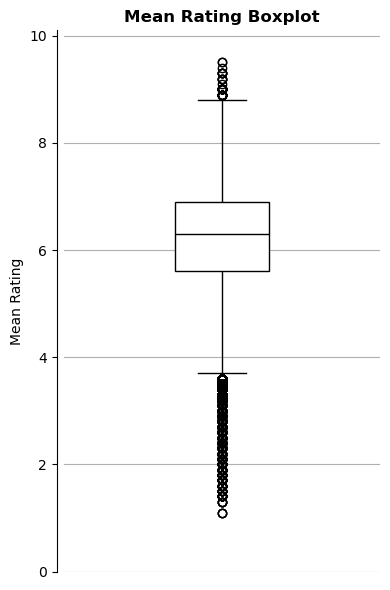

In [74]:
plt.figure(figsize=(4, 6))
ax = sns.boxplot(data=df_movies_tmdb_ratings['averageRating'], color='white', linecolor='black', width=0.3)

# box-plotting the 'mean_rating' column
sns.despine(offset=5, trim=False, bottom=True)
plt.title('Mean Rating Boxplot', weight='bold')
plt.xticks([])
plt.ylim([0,10.1])
plt.ylabel("Mean Rating", fontsize=10)
plt.grid(True)

plt.tight_layout()

As expected, the movie ratings are approximately normally distributed with equivalent whisker sizes in the above boxplot and a median centered about at the centre of the IQR. Many outliers are observed, however we will not consider these as outliers given the data exists over a five point scale and no extreme values greatly drive skew in the movies ratings. The plot below provides further information on the mean movie ratings distribution. Ratings are again given in a range from 0 to 5.

In [75]:
df_movies_tmdb_ratings_unique["averageRating"].min()

1.1

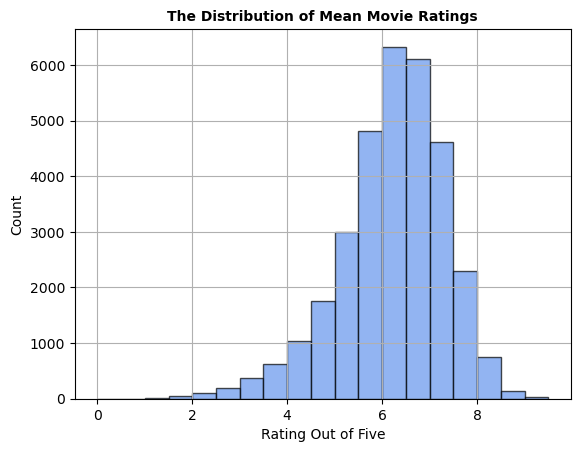

In [76]:
bin_edges = np.arange(0, df_movies_tmdb_ratings_unique['averageRating'].max() + 0.5, 0.5)
plt.hist(df_movies_tmdb_ratings_unique['averageRating'].values, edgecolor='black', alpha=0.7, bins = bin_edges, color='cornflowerblue')
plt.title("The Distribution of Mean Movie Ratings", weight='bold', fontsize=10)
plt.xlabel('Rating Out of Five', fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.grid(True)

Since even through this visualization the distribution resembles a normal one, some test to verify this hypothesis are run below.

In [77]:
diagnostic.kstest_normal(df_movies_tmdb_ratings_unique['averageRating'].values, dist = 'norm') 

(0.0714799519786698, 0.0009999999999998899)

Although the mean rating normality test returns a low p-value, visual inspections of the ratings distribution lead to a different conclusion. Therefore, a Q-Q plot is again employed to further assess normality.

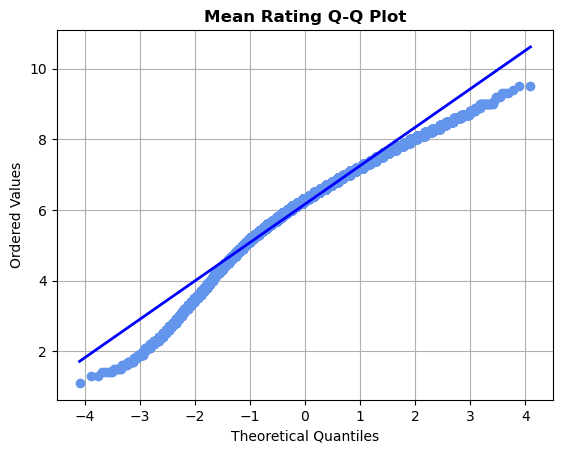

In [78]:
# ploting Q-Q test
fig, ax = plt.subplots()
res = stats.probplot(df_movies_tmdb_ratings_unique['averageRating'].values, dist="norm", plot=ax)

# line settings
line = ax.get_lines()[0]
line_normal = ax.get_lines()[1]
line.set_color('cornflowerblue') 
line.set_linewidth(2)
line_normal.set_color('blue') 
line_normal.set_linewidth(2)

plt.title("Mean Rating Q-Q Plot", weight='bold')
plt.xlabel("Theoretical Quantiles", fontsize=10)
plt.ylabel("Ordered Values", fontsize=10)
plt.grid(True)

Given the central portion of the Q-Q plot is flatter and the edges steeper, we again conclude that mean ratings is approximately normally distributed but there are more datapoints aggregated about the mean than there would be in the case of a normal distribution.

Now, a closer look to genres preferences is presented. The objective is to visualize if the mean movie rating changes, based on the movie genre.

In [79]:
genres_total = df_movies_tmdb_ratings.groupby("genres").count().sort_values("wikipedia_id", ascending=False).reset_index()
top_20_genres = genres_total.loc[:19, "genres"]
df_movies_tmdb_ratings_top20genres = df_movies_tmdb_ratings[df_movies_tmdb_ratings["genres"].isin(top_20_genres)]

top_20_genres_list = top_20_genres.to_list()

Text(50.72222222222221, 0.5, 'Genres')

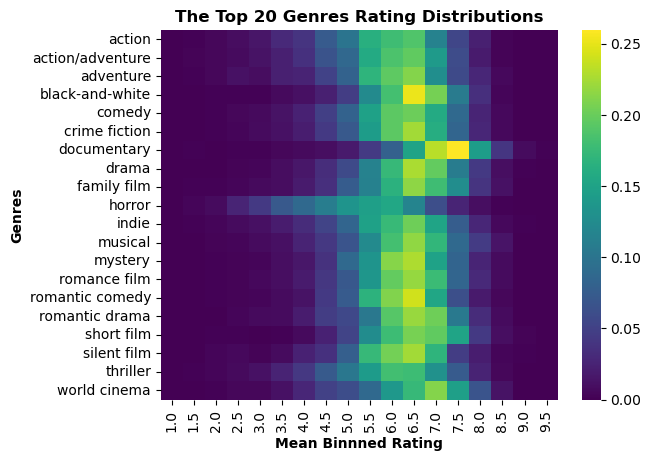

In [80]:
# making the mean of each movie's rating an increment of 0.5
df_movies_tmdb_ratings_top20genres_binnedratings = df_movies_tmdb_ratings_top20genres.copy()
df_movies_tmdb_ratings_top20genres_binnedratings["averageRating"] = df_movies_tmdb_ratings_top20genres_binnedratings["averageRating"].apply(lambda x: round(x*2)/2)

df_genres_meanratings = pd.crosstab(df_movies_tmdb_ratings_top20genres_binnedratings['genres'],df_movies_tmdb_ratings_top20genres_binnedratings['averageRating'], normalize='index')

# creating an heatmap among the top 20 genres
ax = plt.axes()
sns.heatmap(df_genres_meanratings, annot=False, cmap='viridis', ax = ax)

ax.set_title('The Top 20 Genres Rating Distributions', weight='bold')
ax.set_xlabel('Mean Binnned Rating', weight='bold')
ax.set_ylabel('Genres', weight='bold')

The top 20 genres reported in the CMU dataset all have approximately normal distributions with peaks (means) between the 3.0 and 3.5 rating bins, as expected given the population's mean rating of 3.15. Noticeably, horror and science fiction movies have comparatively stronger left-skews than the other main genres for ratings.

Since no evident movie genre preference has been found, other parameters are compared to the mean rating, to find correlations. For example, runtime and release date.

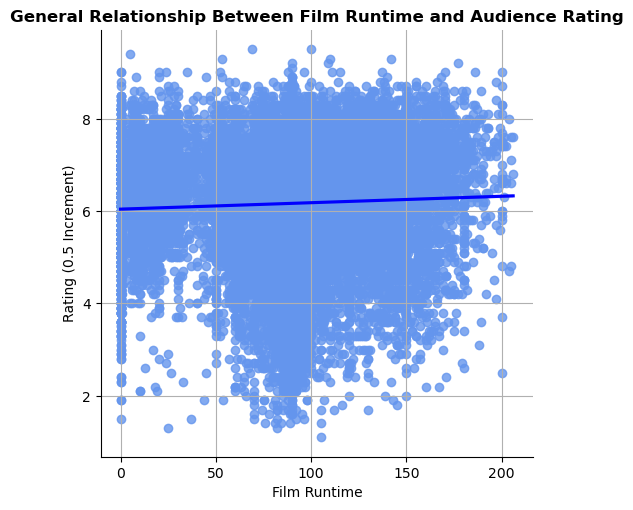

In [81]:
# starting by plotting the relationship between runtime and mean rating
runtime_binned_ratings = df_movies_tmdb_ratings_unique[['runtime','averageRating']]
sns.lmplot(x='runtime',y='averageRating', data=runtime_binned_ratings, scatter_kws={'color': 'cornflowerblue'}, line_kws={'color': 'blue'})
plt.xlabel("Film Runtime")
plt.ylabel("Rating (0.5 Increment)")
plt.title("General Relationship Between Film Runtime and Audience Rating", weight='bold')
plt.grid(True)
plt.show()

From the above graph, it can be concluded that there may be a relationship between runtime of a movie and the audience rating. Indeed, the linear regression segment has a positive coefficient. The above analysis performed over all regions and then across time worldwide and per region would give meaningful insights to understand regional movies preferences

The same plot has been computed to compare the rating and the release date.

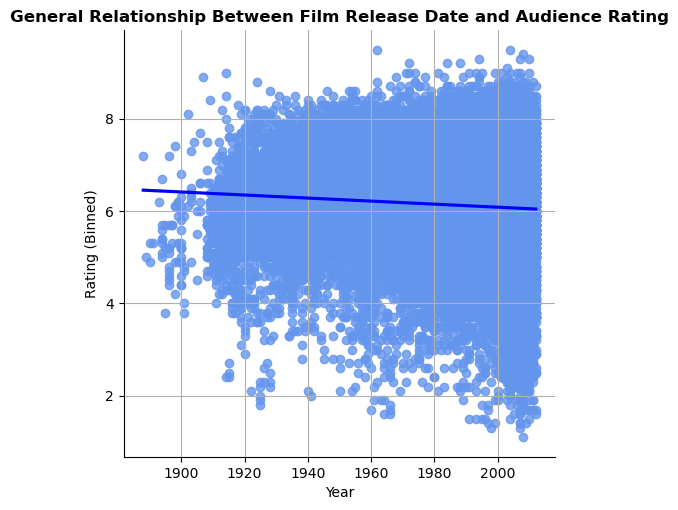

In [82]:
# plot the relationship between release date and mean rating
runtime_binned_ratings = df_movies_tmdb_ratings_unique[['release_date','averageRating']]
sns.lmplot(x='release_date',y='averageRating', data=runtime_binned_ratings, scatter_kws={'color': 'cornflowerblue'}, line_kws={'color': 'blue'})
plt.xlabel("Year")
plt.ylabel("Rating (Binned)")
plt.title("General Relationship Between Film Release Date and Audience Rating", weight='bold')
plt.grid(True)
plt.show()

The above plot leads us to suspect that regional trends of time's influence on movies ratings are required, given across all movies and all countries, a meaningless relation between the two features is observed. Additionally, time-based analysis will be required with more statistically-based methods, as demonstrated further below.

# Film ratings across regions and genres, over time

To simplify this analysis, the top twenty genres of movies are analyzed for their ratings across geographical regions and time of production.

In [83]:
# Identifying the continents and genres of interest
model_groupings = ['Central and South America', 'Eastern Europe', 'India',  
                   'North Africa and Middle East', "North America", "Oceania", 'Remaining Asia', 'South Africa and Central Africa', 'Western Europe']

In [84]:
# Storing colors for plotting later on (extending the colors list to 20 genres)
colors = plt.colormaps['tab20'].colors

In [85]:
# Identifying if any country does not have a particular genre
for genre in top_20_genres_list:
    genre_df = df_movies_tmdb_ratings[df_movies_tmdb_ratings["genres"] == genre]
    regions_with_genre = genre_df["region"].unique()
    regions_with_genre = regions_with_genre.tolist()
    if len(regions_with_genre) < 9:
        for i in model_groupings:
            if i not in regions_with_genre:
                print(f"The geographical region {i} does not have a movie for the genre {genre}.")

The geographical region South Africa and Central Africa does not have a movie for the genre black-and-white.
The geographical region North Africa and Middle East does not have a movie for the genre indie.
The geographical region South Africa and Central Africa does not have a movie for the genre musical.
The geographical region North Africa and Middle East does not have a movie for the genre silent film.
The geographical region South Africa and Central Africa does not have a movie for the genre silent film.


In [86]:
# Filling a copy dataframe with blank movie(s) for the missing genre(s) of any geographic region, to ensure no errors when plotting below
df_movies_tmdb_ratings_regionfilled = df_movies_tmdb_ratings.copy()
for genre in top_20_genres_list:
    genre_df = df_movies_tmdb_ratings_regionfilled[df_movies_tmdb_ratings_regionfilled["genres"] == genre]
    regions_with_genre = genre_df["region"].unique()
    regions_with_genre = regions_with_genre.tolist()
    if len(regions_with_genre) < 9:
        for i in model_groupings:
            if i not in regions_with_genre:
                    new_row = {"region": i, "genres": genre, "averageRating": 0.0}
                    df_movies_tmdb_ratings_regionfilled = pd.concat([df_movies_tmdb_ratings_regionfilled, pd.DataFrame([new_row])], ignore_index=True)
# Identifying if any country does not have a particular genre again, which shouldn't be the case
for genre in top_20_genres_list:
    genre_df = df_movies_tmdb_ratings_regionfilled[df_movies_tmdb_ratings_regionfilled["genres"] == genre]
    regions_with_genre = genre_df["region"].unique()
    regions_with_genre = regions_with_genre.tolist()
    if len(regions_with_genre) < 9:
        for i in model_groupings:
            if i not in regions_with_genre:
                print(f"The geographical region {i} does not have a movie for the genre {genre}.")
    else:
        print(f"Every region has at least one {genre} movie.")

Every region has at least one drama movie.
Every region has at least one comedy movie.
Every region has at least one romance film movie.
Every region has at least one black-and-white movie.
Every region has at least one action movie.
Every region has at least one thriller movie.
Every region has at least one crime fiction movie.
Every region has at least one indie movie.
Every region has at least one short film movie.
Every region has at least one world cinema movie.
Every region has at least one action/adventure movie.
Every region has at least one horror movie.
Every region has at least one adventure movie.
Every region has at least one family film movie.
Every region has at least one musical movie.
Every region has at least one documentary movie.
Every region has at least one romantic drama movie.
Every region has at least one mystery movie.
Every region has at least one romantic comedy movie.
Every region has at least one silent film movie.


In [87]:
# Dictionaries are required to store the mean ratings and confidence intervals of movies per genre per region
mean_ratings = {}
confidence_intervals = {}

# Loop through each genre and calculate the necessary values
for genre in top_20_genres_list:
    genre_df = df_movies_tmdb_ratings_regionfilled[df_movies_tmdb_ratings_regionfilled["genres"] == genre]

    # Group by region and calculate mean ratings and stderr
    genre_mean_ratings = genre_df.groupby("region")

    genre_mean_ratings_size = genre_mean_ratings.size().sort_index()
    genre_mean_ratings_regions_average = genre_mean_ratings.mean("averageRating").apply(lambda x: round(x*2)/2).sort_index()
    genre_mean_ratings_regions_std = genre_mean_ratings["averageRating"].std().sort_index()  
    genre_mean_ratings_regions_stderr = genre_mean_ratings_regions_std / np.sqrt(genre_mean_ratings_size)  

    # Store the mean ratings and confidence intervals for the genre
    genre_means = []
    genre_CI = []
    for region in model_groupings:
        # To ensure validity of results, must ensure a given region grouping for a given genre has at least 10 movies for their associated statistics to be reported
        if genre_mean_ratings_size.loc[region]<10:
            mean_rating = 0.0
            genre_means.append(mean_rating)
        else:
            mean_rating = genre_mean_ratings_regions_average.loc[region]["averageRating"]
            genre_means.append(mean_rating)

        # Calculate the 95% confidence interval (mean +/- 1.96 * stderr)
        if genre_mean_ratings_size.loc[region]<10:
            CI = 0.0
            genre_CI.append(CI)
        else:
            CI = genre_mean_ratings_regions_stderr.loc[region] * 1.96
            genre_CI.append(CI)

    # Append the results to the dictionaries
    mean_ratings[genre] = genre_means
    confidence_intervals[genre] = genre_CI

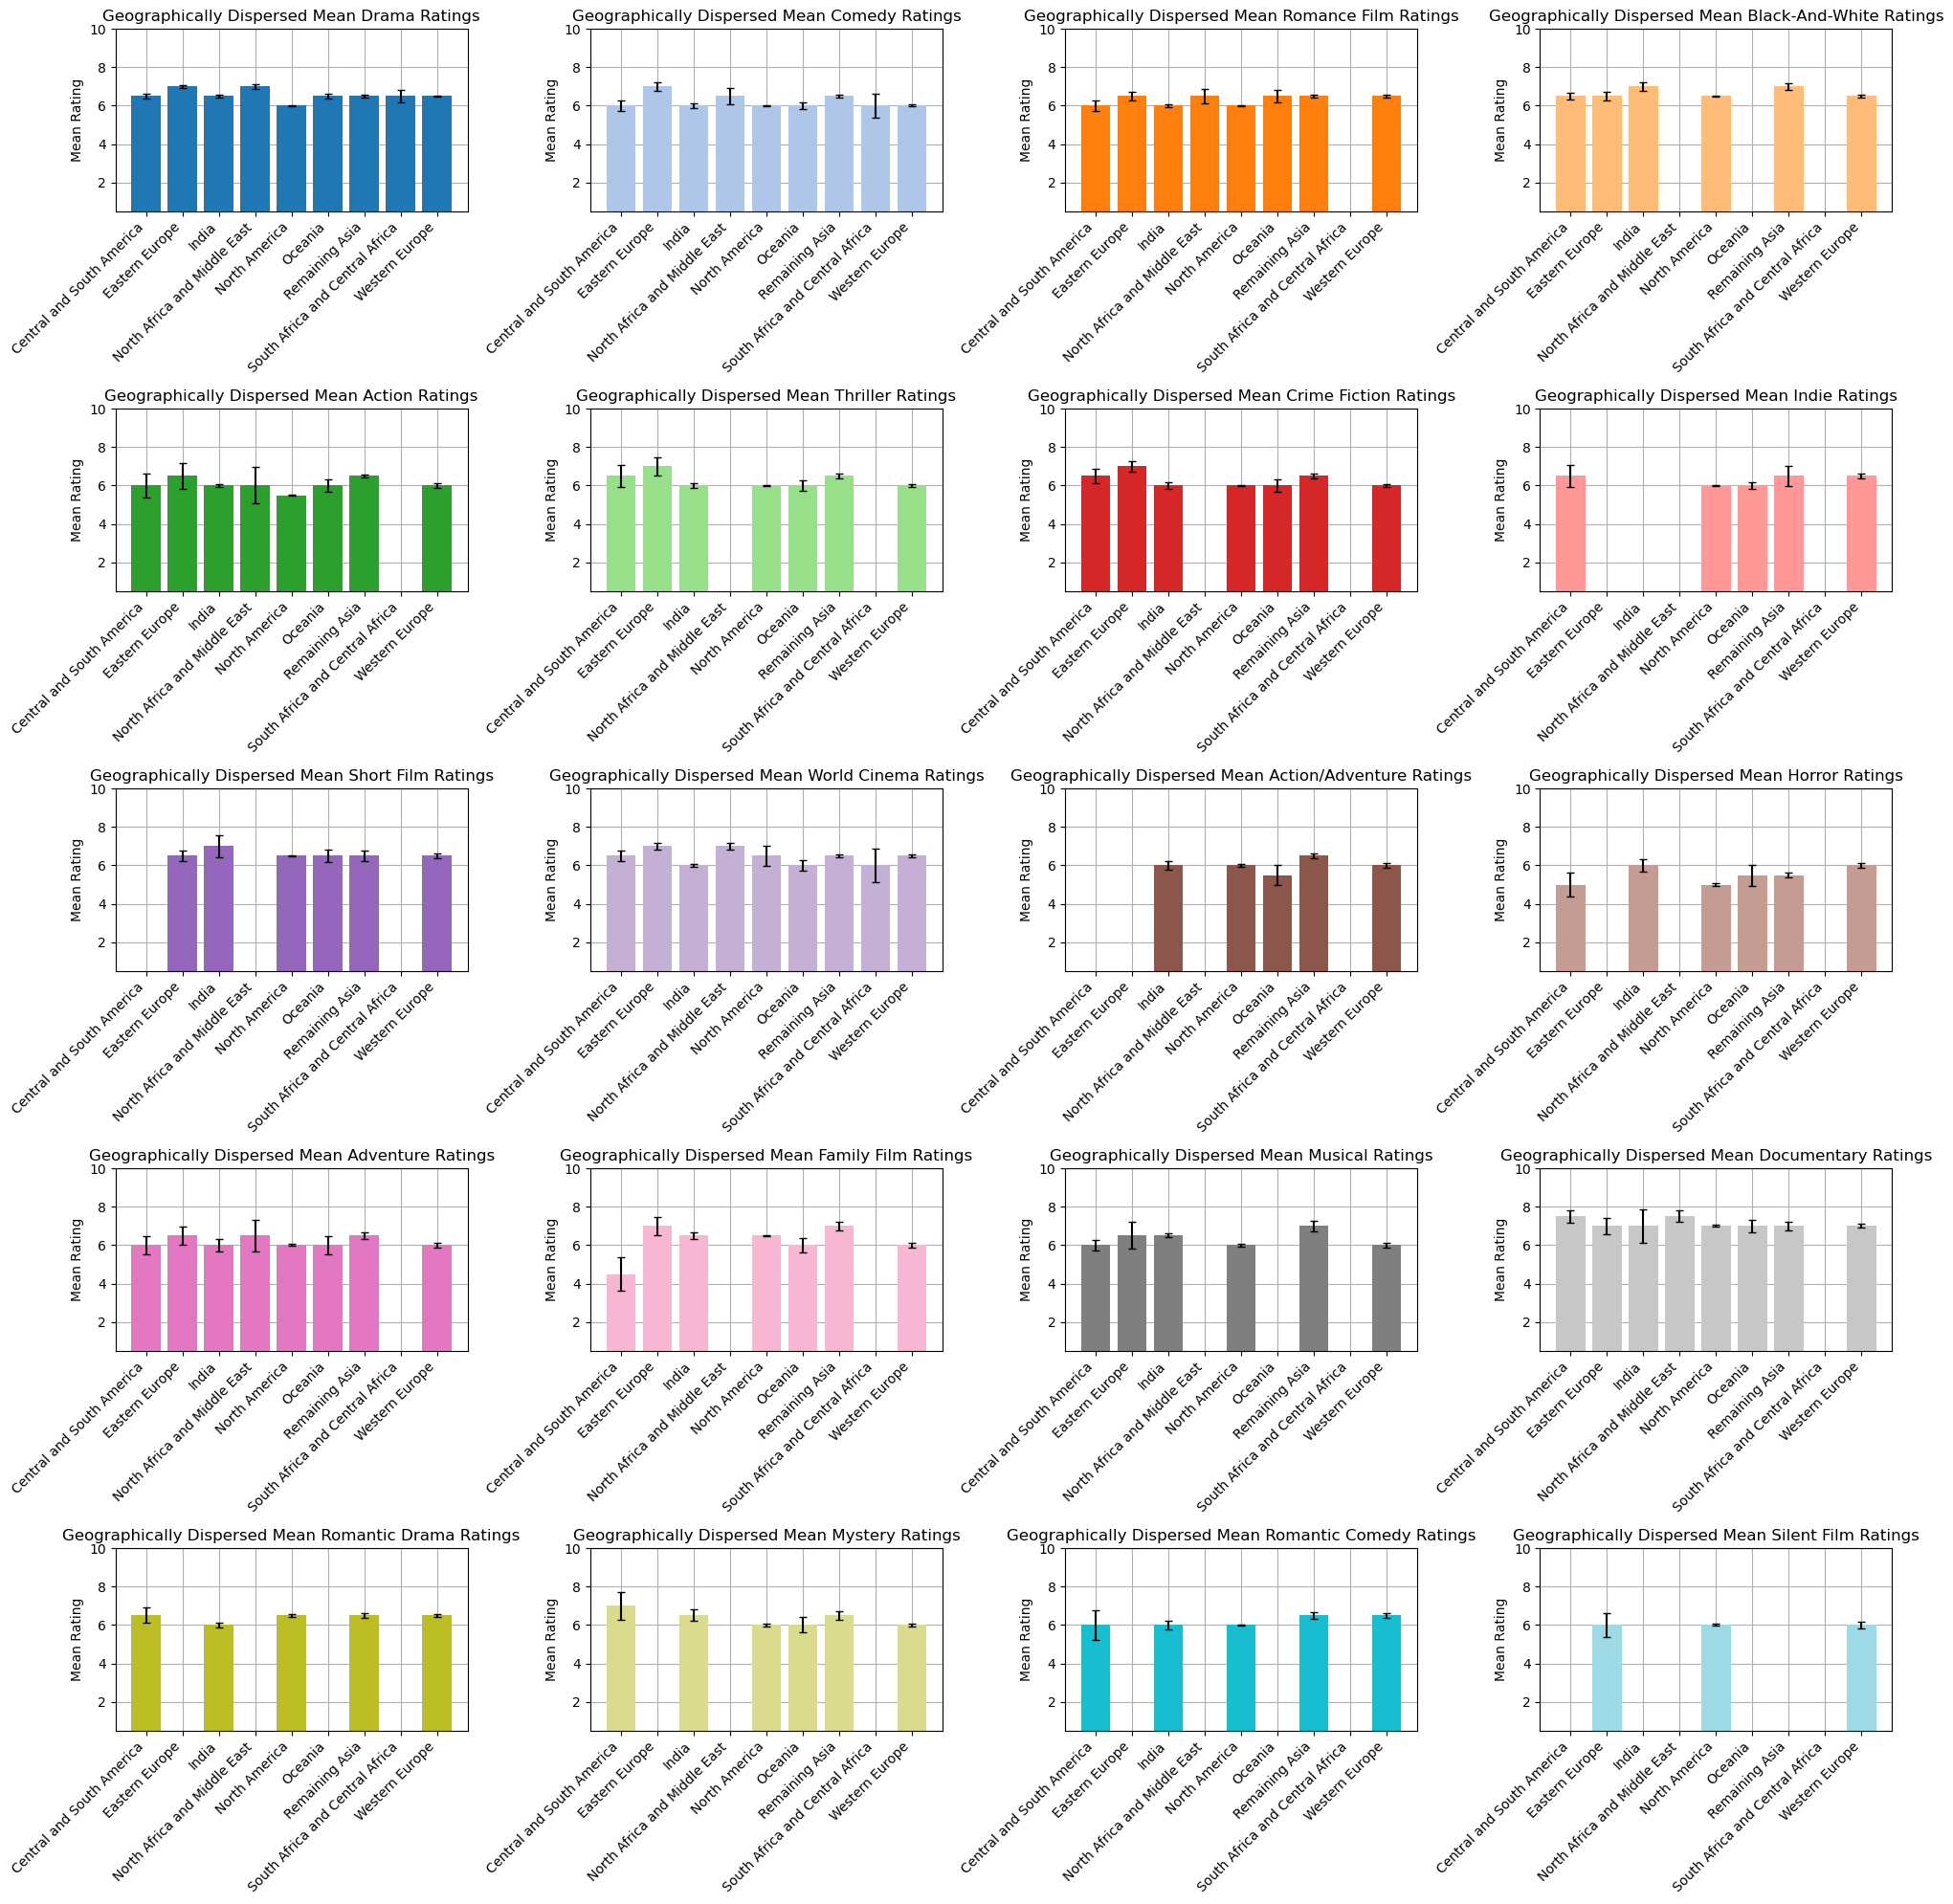

In [88]:
# Create a 5x4 grid for the subplots to fit 20 genres
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
axs = axs.flatten()

# Plot each genre in the corresponding subplot
for i, genre in enumerate(top_20_genres_list):
    axs[i].bar(range(len(model_groupings)), mean_ratings[genre], yerr=confidence_intervals[genre], capsize=3, color=colors[i], zorder=2)

    axs[i].grid(True, zorder=0)
    axs[i].set_xticks(range(len(model_groupings)))
    axs[i].set_xticklabels(model_groupings, rotation=45, ha='right')
    axs[i].set_title(f"Geographically Dispersed Mean {genre.title()} Ratings")
    axs[i].set_ylabel("Mean Rating")
    axs[i].set_ylim(0.5, 10)

# Adjust layout to fit everything well
plt.tight_layout()
plt.show()

Now I want to explore how within each geographical region the mean ratings of movies by genre differ.

In [89]:
# Dictionaries are required to store the mean ratings and confidence intervals of movies per genre per region
mean_ratings = {}
confidence_intervals = {}

# Loop through each genre and calculate the necessary values
for region in model_groupings:
    region_df = df_movies_tmdb_ratings_regionfilled[df_movies_tmdb_ratings_regionfilled["region"] == region]

    # Group by region and calculate mean ratings and stderr
    genre_mean_ratings = region_df.groupby("genres")

    genre_mean_ratings_size = genre_mean_ratings.size().sort_index()
    genre_mean_ratings_regions_average = genre_mean_ratings.mean("averageRating").apply(lambda x: round(x*2)/2).sort_index()
    genre_mean_ratings_regions_std = genre_mean_ratings["averageRating"].std().sort_index()  
    genre_mean_ratings_regions_stderr = genre_mean_ratings_regions_std / np.sqrt(genre_mean_ratings_size)  

    # Store the mean ratings and confidence intervals for the genre
    region_means = []
    region_CI = []
    for genre in top_20_genres_list:
        mean_rating = genre_mean_ratings_regions_average.loc[genre]["averageRating"]
        region_means.append(mean_rating)

        # Calculate the 95% confidence interval (mean +/- 1.96 * stderr)
        CI = genre_mean_ratings_regions_stderr.loc[genre] * 1.96
        region_CI.append(CI)

    # Append the results to the dictionaries
    mean_ratings[region] = region_means
    confidence_intervals[region] = region_CI

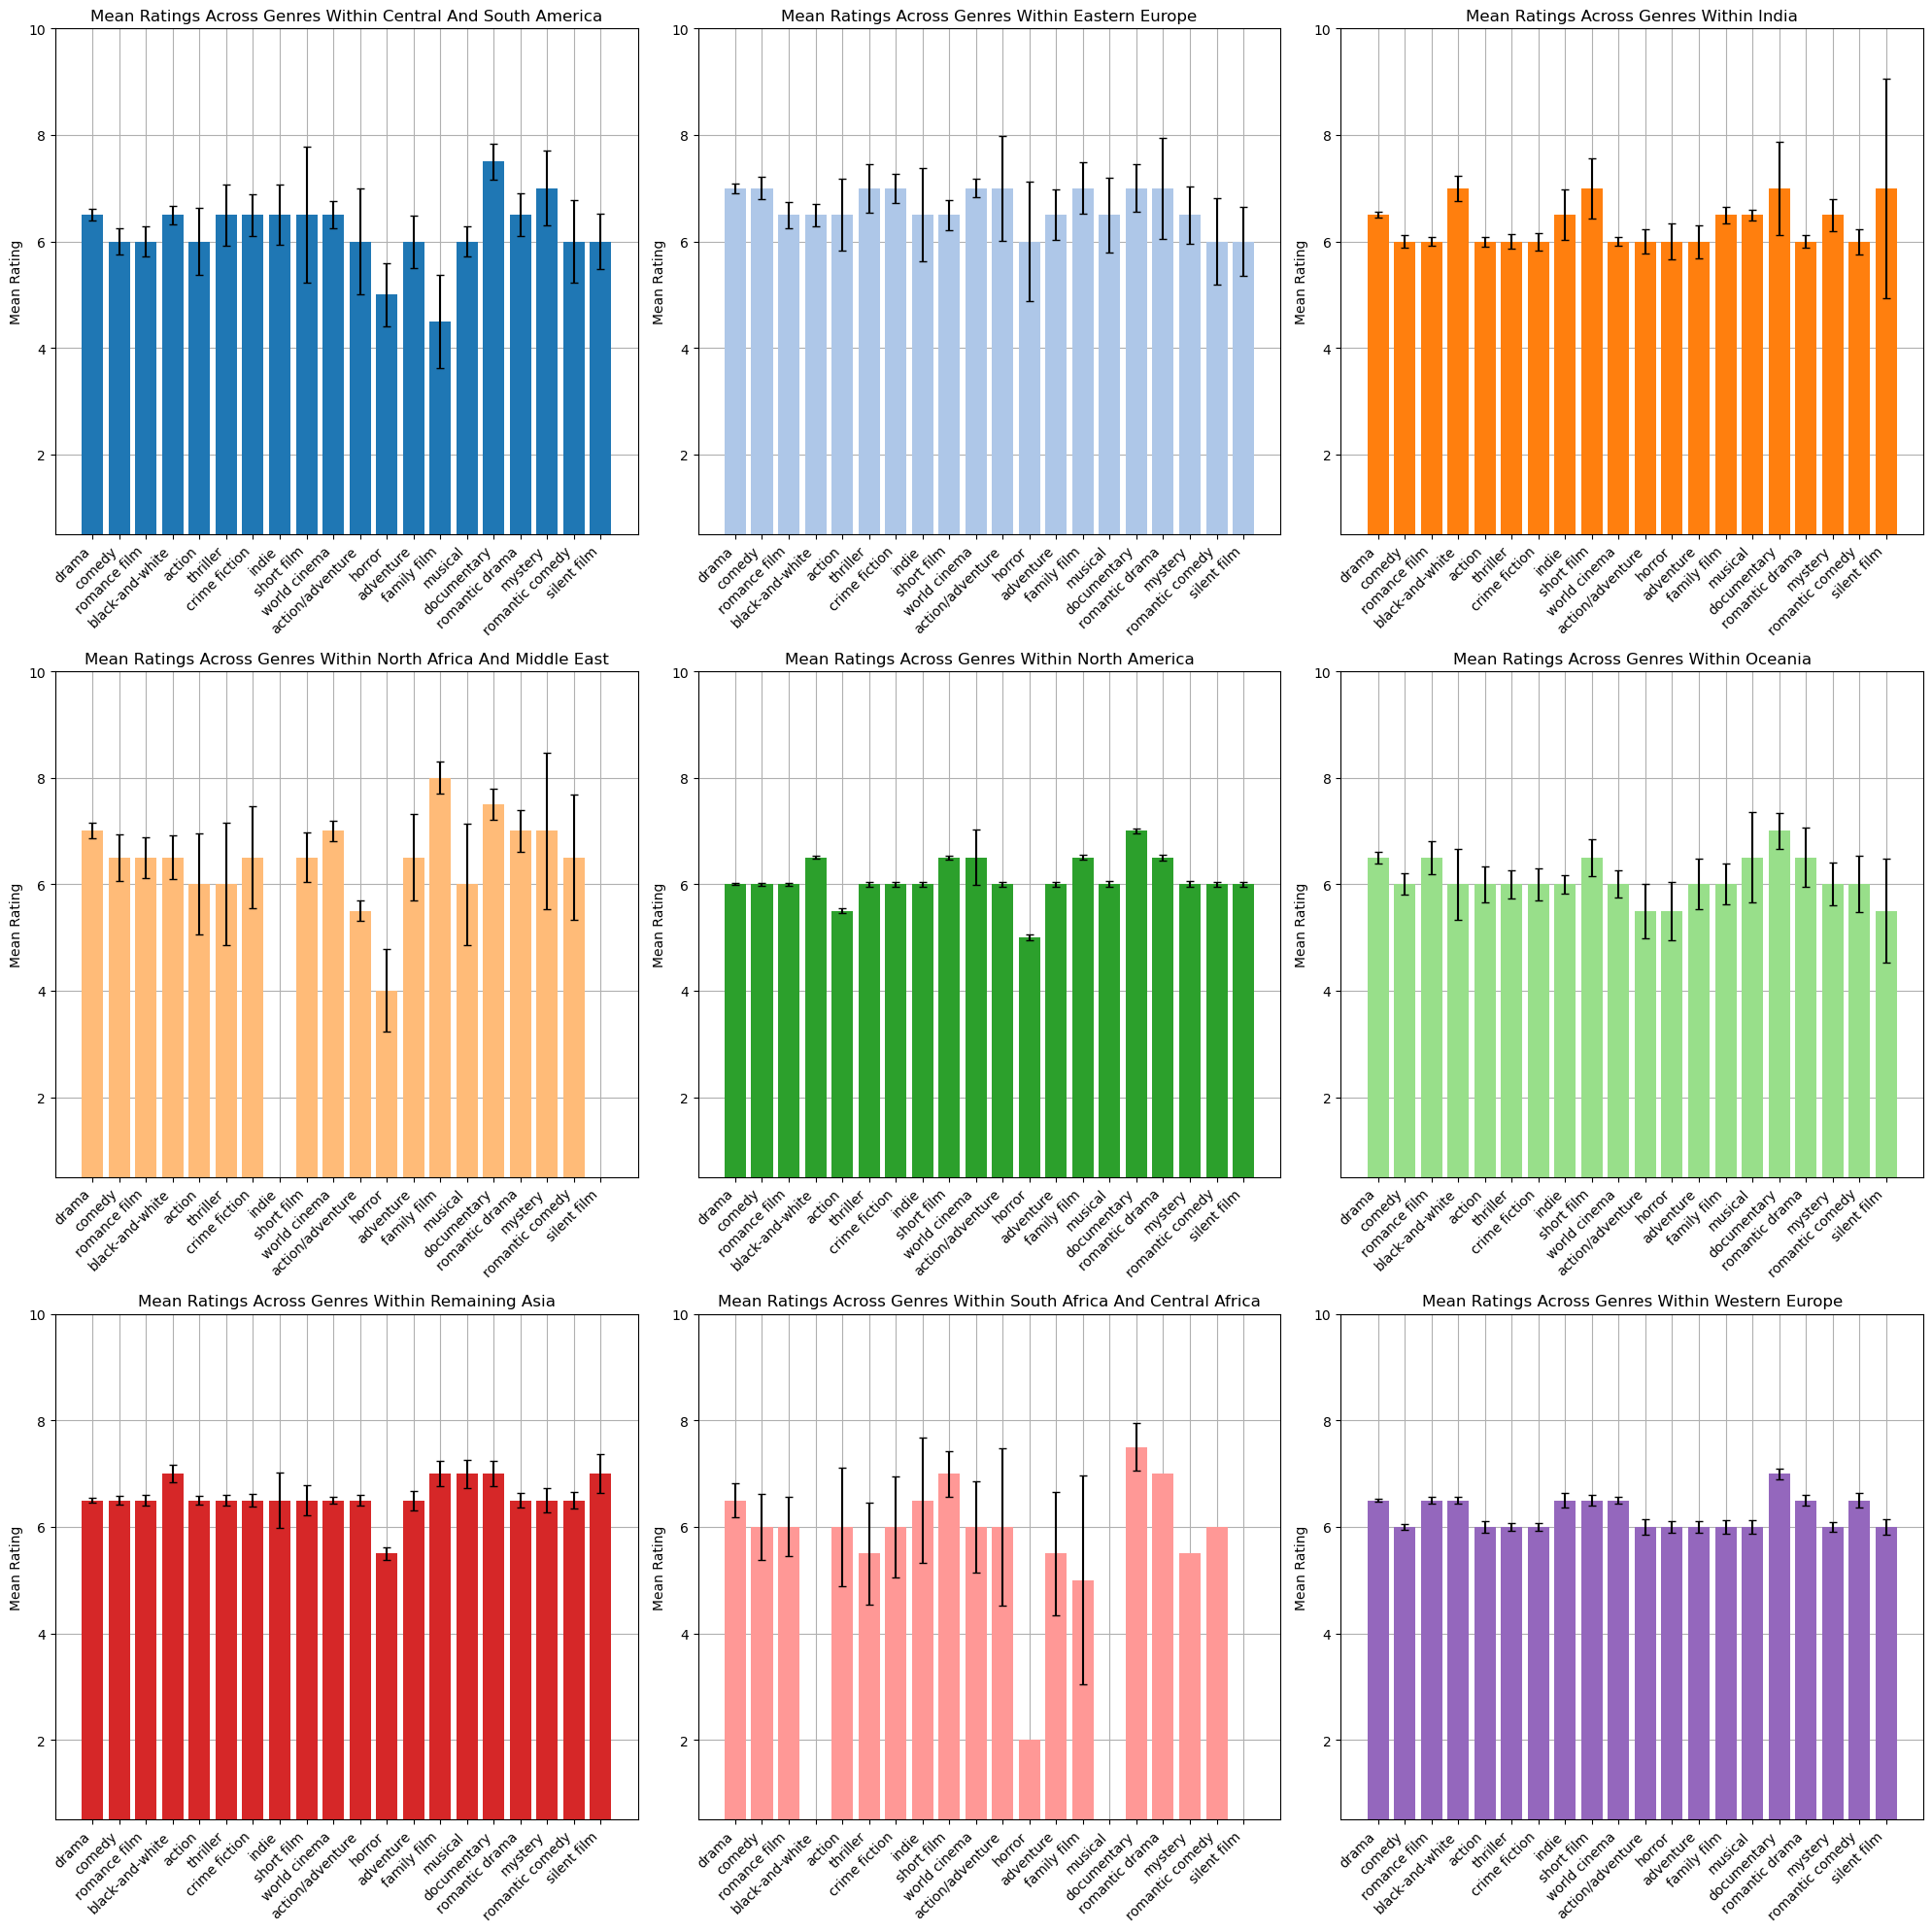

In [90]:
# Create a 3x3 grid for the subplots to fit 9 regions
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()

# Plot each genre in the corresponding subplot
for i, region in enumerate(model_groupings):
    axs[i].bar(range(len(top_20_genres_list)), mean_ratings[region], yerr=confidence_intervals[region], capsize=3, color=colors[i], zorder=2)

    axs[i].grid(True, zorder=0)
    axs[i].set_xticks(range(len(top_20_genres_list)))
    axs[i].set_xticklabels(top_20_genres_list, rotation=45, ha='right')
    axs[i].set_title(f"Mean Ratings Across Genres Within {region.title()}")
    axs[i].set_ylabel("Mean Rating")
    axs[i].set_ylim(0.5, 10)

# Adjust layout to fit everything well
plt.tight_layout()
plt.show()

Now I want to observe how the mean rating per genre per region changes over time.

In [91]:
# The movies must be 'binned' into the decade in which they were released
def categorize_decade(release_date):
    if 1950 <= release_date < 1960:
        return '1950'
    elif 1960 <= release_date < 1970:
        return '1960'
    elif 1970 <= release_date < 1980:
        return '1970'
    elif 1980 <= release_date < 1990:
        return '1980'
    elif 1990 <= release_date < 2000:
        return '1990'
    elif 2000 <= release_date < 2010:
        return '2000'
    else:
        return None

# A copy of the ratings dataframe is used to store the movies with their binned decade of release included as a new feature
df_movies_tmdb_ratings_decades = df_movies_tmdb_ratings_regionfilled.copy()
df_movies_tmdb_ratings_decades["decade"] = df_movies_tmdb_ratings_decades["release_date"].apply(categorize_decade)
df_movies_tmdb_ratings_decades.dropna(subset=['decade'], inplace=True)

In [92]:
# Defining the decades of interest
decades = ["1950", "1960", "1970", "1980", "1990", "2000"]

# A copy dataframe with blank movie(s) for the missing genre(s) of any geographic region in any deacde is required, to ensure no errors when plotting below
df_movies_tmdb_ratings_region_decade_filled = df_movies_tmdb_ratings_decades.copy()
for genre in top_20_genres_list:
    genre_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["genres"] == genre]
    for region in regions:
        genre_region_df = genre_df[genre_df["region"] == region]
        regions_with_genre_decade = genre_region_df["decade"].unique()
        regions_with_genre_decade = regions_with_genre_decade.tolist()
        if len(regions_with_genre_decade) < 6:
            for i in decades:
                if i not in regions_with_genre_decade:
                    new_row = {"region": region, "genres": genre, "averageRating": 0.0, "decade": i}
                    df_movies_tmdb_ratings_region_decade_filled = pd.concat([df_movies_tmdb_ratings_region_decade_filled, pd.DataFrame([new_row])], ignore_index=True)

In [93]:
# Dictionaries are required to store the mean ratings and confidence intervals of movies per genre per region over decades, from the 50's onwards
mean_ratings = {}
confidence_intervals = {}

# Looping through each genre to calculate the mean rating and CI per genre of film per region per decade
for region in model_groupings:
    region_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["region"] == region]

    # Grouping by region and calculate mean ratings and stderr; here, the mean ratings per genre per decade in a given region are not rounded to the nearest 0.5
    genre_mean_ratings = region_df.groupby(["genres", "decade"])

    genre_mean_ratings_size = genre_mean_ratings.size().sort_index()
    genre_mean_ratings_regions_average = genre_mean_ratings.mean("averageRating").sort_index()
    genre_mean_ratings_regions_std = genre_mean_ratings["averageRating"].std().sort_index()  
    genre_mean_ratings_regions_stderr = genre_mean_ratings_regions_std / np.sqrt(genre_mean_ratings_size)  

    # Storing the mean ratings and confidence intervals for the genre in the region across decades
    region_means = np.zeros((20, 6))
    region_CI = np.zeros((20, 6))

    for i, genre in enumerate(top_20_genres_list):
        # To ensure validity of results, must ensure a given region and decade grouping for a given genre has at least 3 movies for their associated statistics to be reported
        for j, decade in enumerate(decades):
            if genre_mean_ratings_size.loc[(genre, decade)]<3:
                region_means[i][j] = 0.0
                region_CI[i][j] = 0.0
            else:
                region_means[i][j] = genre_mean_ratings_regions_average.loc[(genre, decade), "averageRating"]
                region_CI[i][j] = genre_mean_ratings_regions_stderr.loc[(genre, decade)] * 1.96

    # Appending the results to the dictionaries
    mean_ratings[region] = region_means
    confidence_intervals[region] = region_CI

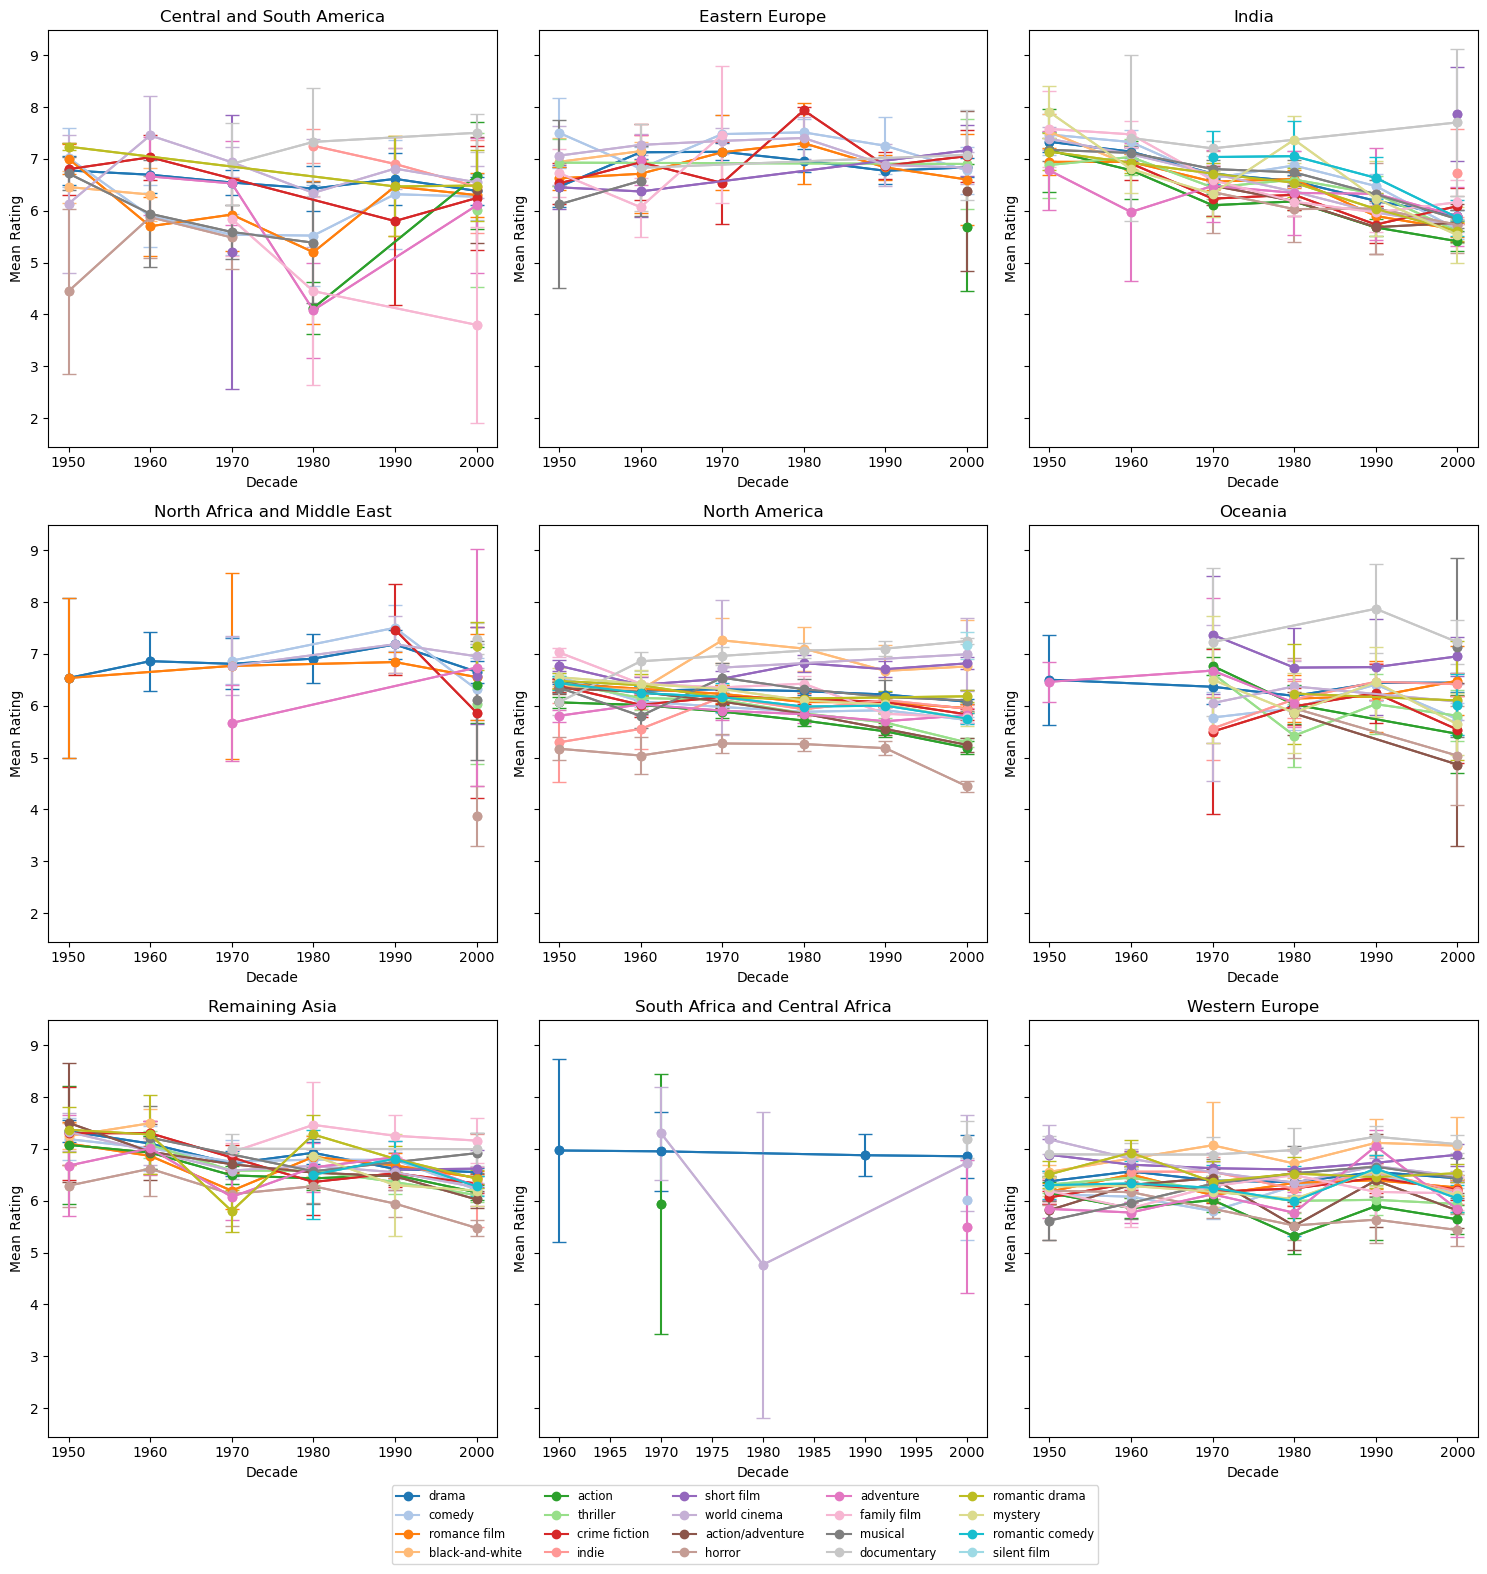

In [94]:
# Defining the subplots, with one per region
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True)
axes = axes.flatten()

# Creating the subplot per region of their mean ratings for the top 20 genres of films over the six decades considered
for i, region_name in enumerate(mean_ratings.keys()):
    ax = axes[i]

    # Each genre is stored as a row in the mean and confidence interval dictionaries and must have their mean ratings and CI per decade paired and plotted
    for j, (mean, stderr) in enumerate(zip(mean_ratings[region_name], confidence_intervals[region_name])):

        # As some means were made to be 0.0 if under three movies were given for that genre in that decade per region, these datapoints must not be plotted
        mask = np.array(mean) != 0
        filtered_means = np.array(mean)[mask]
        filtered_stderrs = np.array(stderr)[mask]

        # The mask must be applied to the decades (x-values) over which the mean ratings are being plotted to ensure the correct rating is placed at the correct decade
        filtered_decades = np.array(decades)[mask]

        # The visualization of genre mean ratings over decades per region requires numerical forms of the decade list previously made
        decade_map = {}
        for i in decades:
            decade_map[i] = int(i)
        filtered_decades_as_int = []
        for i in filtered_decades:
            filtered_decades_as_int.append(decade_map[i])

        # To ensure the subfigure's ratings are plotted chronologically, the decades of a genre with a mean rating reported must be sorted
        sorted_indices = np.argsort(filtered_decades_as_int)

        # The saved indeces of the decades to ensure they're chronologically ordered must be used to sort the genres mean ratings and associated CI
        filtered_decades = np.array(filtered_decades_as_int)[sorted_indices]
        filtered_means = filtered_means[sorted_indices]
        filtered_stderrs = filtered_stderrs[sorted_indices]

        # Defining the given genres color for plotting a line plot with error bars for every genres mean rating over the six decades in a given region
        color = colors[j]
        ax.errorbar(filtered_decades, filtered_means, yerr=filtered_stderrs, label=top_20_genres_list[j], capsize=5, marker='o', color=color)
        ax.plot(filtered_decades, filtered_means, marker='o', color=color)

    ax.set_title(region_name)
    ax.set_xlabel('Decade')
    ax.set_ylabel('Mean Rating')

plt.tight_layout()
fig.legend(labels=top_20_genres_list, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05), fontsize='small')
plt.show()

The above is great but with 20 genres, quite hard to visualize. Let's focus on the top 5 genres to make the observations more interprettable, recycling the code from above.

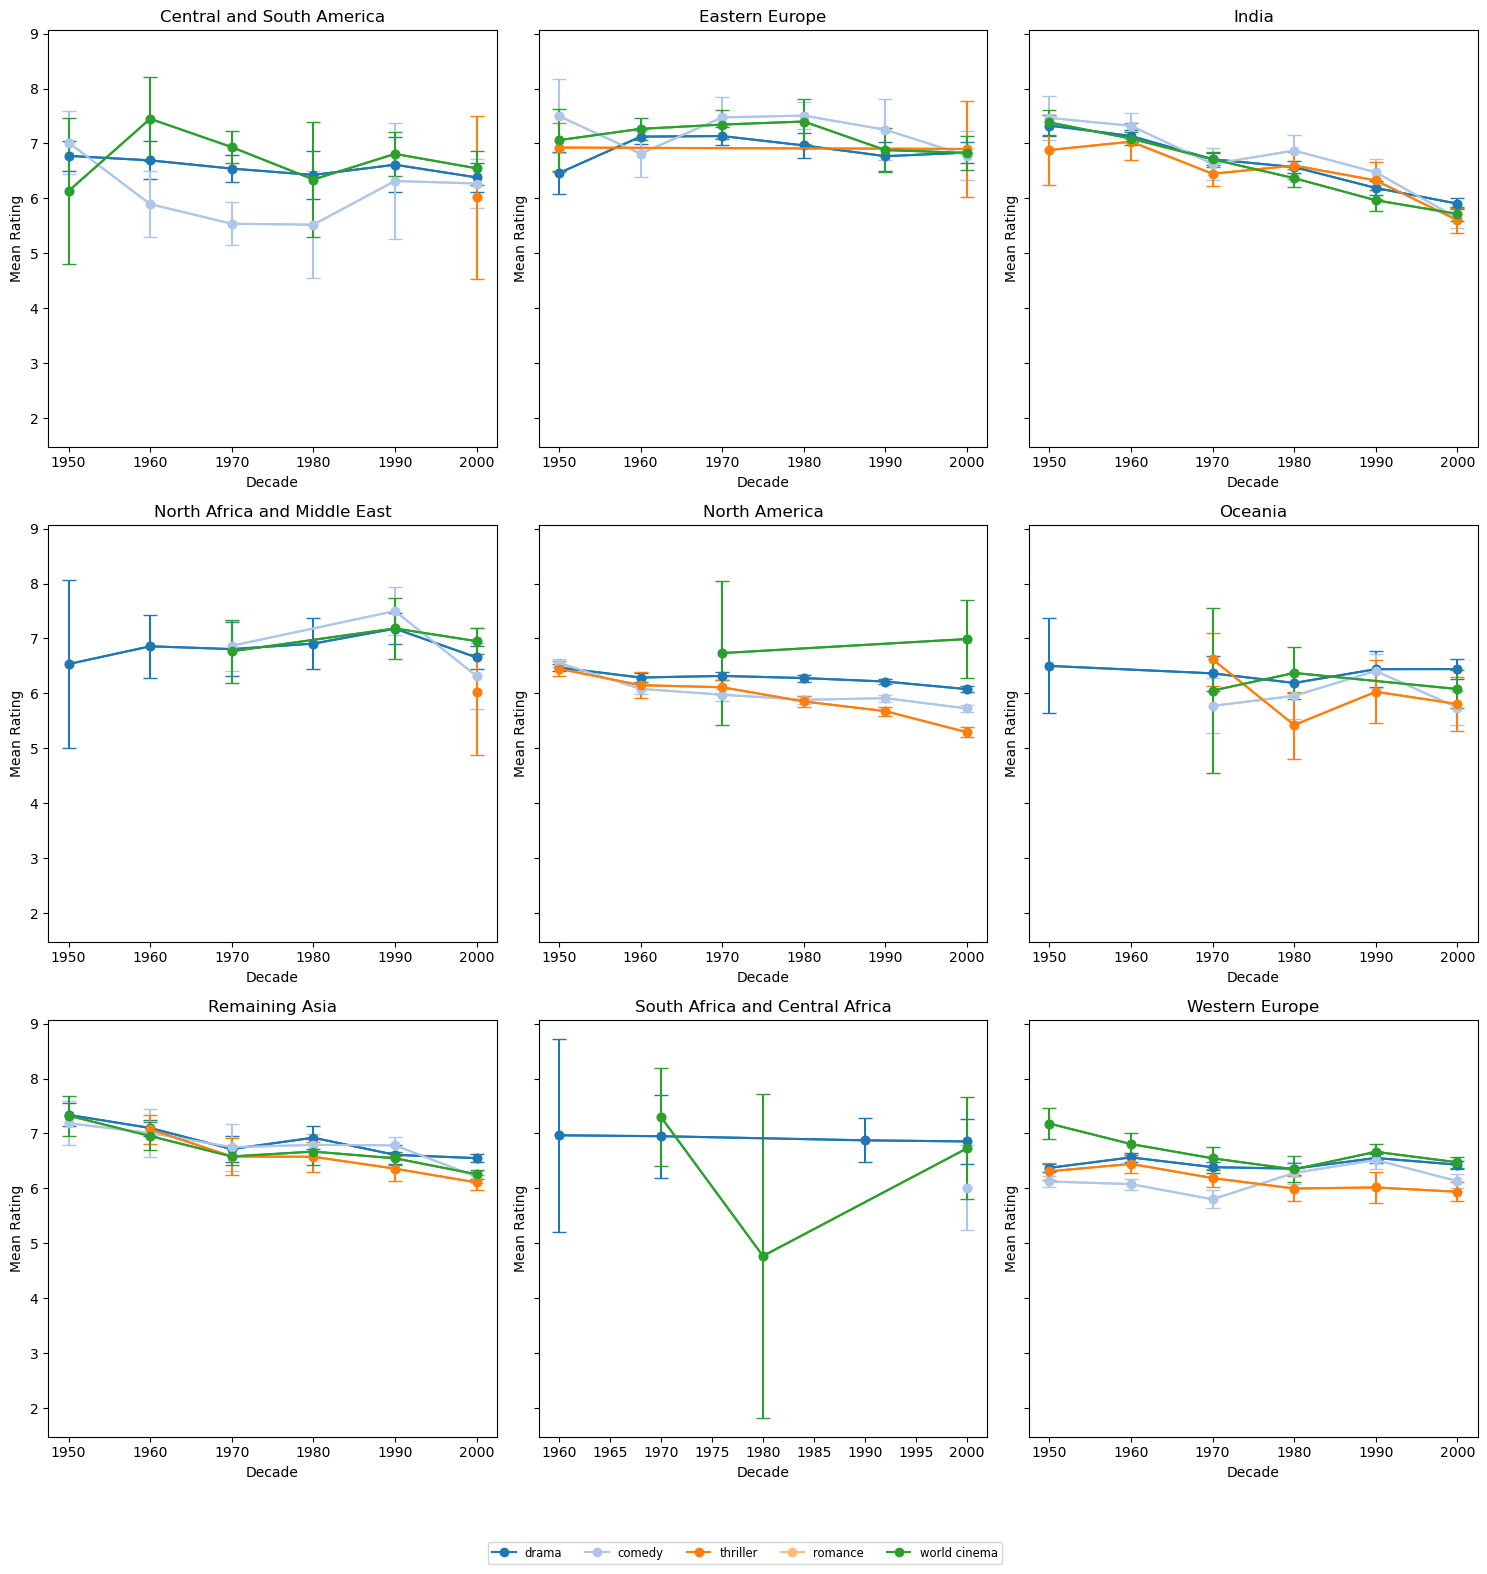

In [95]:
# Re-defining the top 5 genres reported in the TMDB ratings master dataframe
top_5_genres = ["drama", "comedy", "thriller", "romance", "world cinema"]

# The movies must be 'binned' into the decade in which they were released
def categorize_decade(release_date):
    if 1950 <= release_date < 1960:
        return '1950'
    elif 1960 <= release_date < 1970:
        return '1960'
    elif 1970 <= release_date < 1980:
        return '1970'
    elif 1980 <= release_date < 1990:
        return '1980'
    elif 1990 <= release_date < 2000:
        return '1990'
    elif 2000 <= release_date < 2010:
        return '2000'
    else:
        return None

# A copy of the ratings dataframe is used to store the movies with their binned decade of release included as a new feature
df_movies_tmdb_ratings_decades = df_movies_tmdb_ratings_regionfilled.copy()
df_movies_tmdb_ratings_decades["decade"] = df_movies_tmdb_ratings_decades["release_date"].apply(categorize_decade)
df_movies_tmdb_ratings_decades.dropna(subset=['decade'], inplace=True)

# Defining the decades of interest
decades = ["1950", "1960", "1970", "1980", "1990", "2000"]

# A copy dataframe with blank movie(s) for the missing genre(s) of any geographic region in any deacde is required, to ensure no errors when plotting below
df_movies_tmdb_ratings_region_decade_filled = df_movies_tmdb_ratings_decades.copy()
for genre in top_5_genres:
    genre_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["genres"] == genre]
    for region in regions:
        genre_region_df = genre_df[genre_df["region"] == region]
        regions_with_genre_decade = genre_region_df["decade"].unique()
        regions_with_genre_decade = regions_with_genre_decade.tolist()
        if len(regions_with_genre_decade) < 6:
            for i in decades:
                if i not in regions_with_genre_decade:
                    new_row = {"region": region, "genres": genre, "averageRating": 0.0, "decade": i}
                    df_movies_tmdb_ratings_region_decade_filled = pd.concat([df_movies_tmdb_ratings_region_decade_filled, pd.DataFrame([new_row])], ignore_index=True)

# Dictionaries are required to store the mean ratings and confidence intervals of movies per genre per region over decades, from the 50's onwards
mean_ratings = {}
confidence_intervals = {}

# Looping through each region to calculate the mean rating and CI per genre of film per region per decade
for region in model_groupings:
    region_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["region"] == region]

    # Grouping by genre per decade and calculate mean ratings and stderr; here, the mean ratings per genre per decade in a given region are not rounded to the nearest 0.5
    genre_mean_ratings = region_df.groupby(["genres", "decade"])

    genre_mean_ratings_size = genre_mean_ratings.size().sort_index()
    genre_mean_ratings_regions_average = genre_mean_ratings.mean("averageRating").sort_index()
    genre_mean_ratings_regions_std = genre_mean_ratings["averageRating"].std().sort_index()  
    genre_mean_ratings_regions_stderr = genre_mean_ratings_regions_std / np.sqrt(genre_mean_ratings_size)  

    # Storing the mean ratings and confidence intervals for the genre in the region across decades
    region_means = np.zeros((5, 6))
    region_CI = np.zeros((5, 6))

    for i, genre in enumerate(top_5_genres):
        # To ensure validity of results, must ensure a given region and decade grouping for a given genre has at least 3 movies for their associated statistics to be reported
        for j, decade in enumerate(decades):
            if genre_mean_ratings_size.loc[(genre, decade)]<3:
                region_means[i][j] = 0.0
                region_CI[i][j] = 0.0
            else:
                region_means[i][j] = genre_mean_ratings_regions_average.loc[(genre, decade), "averageRating"]
                region_CI[i][j] = genre_mean_ratings_regions_stderr.loc[(genre, decade)] * 1.96

    # Appending the results to the dictionaries
    mean_ratings[region] = region_means
    confidence_intervals[region] = region_CI

    
# Defining the subplots, with one per region
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True)
axes = axes.flatten()

# Creating the subplot per region of their mean ratings for the top 5 genres of films over the six decades considered
for i, region_name in enumerate(mean_ratings.keys()):
    ax = axes[i]

    # Each genre is stored as a row in the mean and confidence interval dictionaries and must have their mean ratings and CI per decade paired and plotted
    for j, (mean, stderr) in enumerate(zip(mean_ratings[region_name], confidence_intervals[region_name])):

        # As some means were made to be 0.0 if under three movies were given for that genre in that decade per region, these datapoints must not be plotted
        mask = np.array(mean) != 0
        filtered_means = np.array(mean)[mask]
        filtered_stderrs = np.array(stderr)[mask]

        # The mask must be applied to the decades (x-values) over which the mean ratings are being plotted to ensure the correct rating is placed at the correct decade
        filtered_decades = np.array(decades)[mask]

        # The visualization of genre mean ratings over decades per region requires numerical forms of the decade list previously made
        decade_map = {}
        for i in decades:
            decade_map[i] = int(i)
        filtered_decades_as_int = []
        for i in filtered_decades:
            filtered_decades_as_int.append(decade_map[i])

        # To ensure the subfigure's ratings are plotted chronologically, the decades of a genre with a mean rating reported must be sorted
        sorted_indices = np.argsort(filtered_decades_as_int)

        # The saved indeces of the decades to ensure they're chronologically ordered must be used to sort the genres mean ratings and associated CI
        filtered_decades = np.array(filtered_decades_as_int)[sorted_indices]
        filtered_means = filtered_means[sorted_indices]
        filtered_stderrs = filtered_stderrs[sorted_indices]

        # Defining the given genres color for plotting a line plot with error bars for every genres mean rating over the six decades in a given region
        color = colors[j]
        ax.errorbar(filtered_decades, filtered_means, yerr=filtered_stderrs, label=top_5_genres[j], capsize=5, marker='o', color=color)
        ax.plot(filtered_decades, filtered_means, marker='o', color=color)

    ax.set_title(region_name)
    ax.set_xlabel('Decade')
    ax.set_ylabel('Mean Rating')

plt.tight_layout()
fig.legend(labels=top_5_genres, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05), fontsize='small')
plt.show()

Interesting! Let's now apply the analysis of comparing ratings across decades to analyzing the ratings across decades between regions per genre.

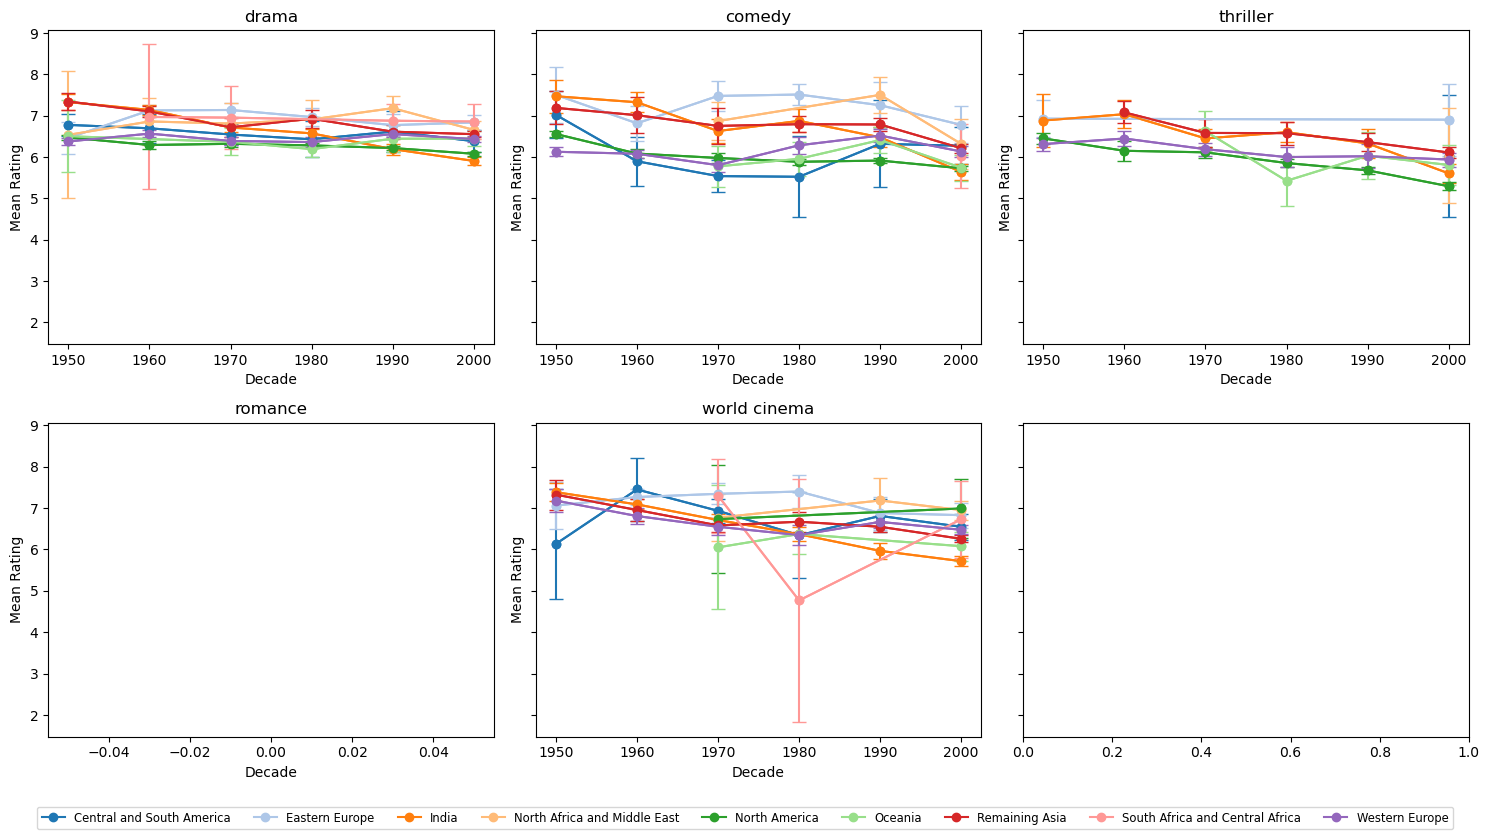

In [96]:
# Re-defining the top 5 genres reported in the TMDB ratings master dataframe
top_5_genres = ["drama", "comedy", "thriller", "romance", "world cinema"]

# The movies must be 'binned' into the decade in which they were released
def categorize_decade(release_date):
    if 1950 <= release_date < 1960:
        return '1950'
    elif 1960 <= release_date < 1970:
        return '1960'
    elif 1970 <= release_date < 1980:
        return '1970'
    elif 1980 <= release_date < 1990:
        return '1980'
    elif 1990 <= release_date < 2000:
        return '1990'
    elif 2000 <= release_date < 2010:
        return '2000'
    else:
        return None

# Defining the decades of interest
decades = ["1950", "1960", "1970", "1980", "1990", "2000"]

# A copy dataframe with blank movie(s) for the missing genre(s) of any geographic region in any deacde is required, to ensure no errors when plotting below
df_movies_tmdb_ratings_region_decade_filled = df_movies_tmdb_ratings_decades.copy()
for genre in top_5_genres:
    genre_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["genres"] == genre]
    for region in regions:
        genre_region_df = genre_df[genre_df["region"] == region]
        regions_with_genre_decade = genre_region_df["decade"].unique()
        regions_with_genre_decade = regions_with_genre_decade.tolist()
        if len(regions_with_genre_decade) < 6:
            for i in decades:
                if i not in regions_with_genre_decade:
                    new_row = {"region": region, "genres": genre, "averageRating": 0.0, "decade": i}
                    df_movies_tmdb_ratings_region_decade_filled = pd.concat([df_movies_tmdb_ratings_region_decade_filled, pd.DataFrame([new_row])], ignore_index=True)

# Dictionaries are required to store the mean ratings and confidence intervals of movies per region per genre over decades, from the 50's onwards
mean_ratings = {}
confidence_intervals = {}

# Looping through each genre to calculate the mean rating and CI per genre of film per region per decade
for genre in top_5_genres:
    genre_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["genres"] == genre]

    # Grouping by region and calculate mean ratings and stderr; here, the mean ratings per genre per decade in a given region are not rounded to the nearest 0.5
    region_mean_ratings = genre_df.groupby(["region", "decade"])

    region_mean_ratings_size = region_mean_ratings.size().sort_index()
    region_mean_ratings_regions_average = region_mean_ratings.mean("averageRating").sort_index()
    region_mean_ratings_regions_std = region_mean_ratings["averageRating"].std().sort_index()  
    region_mean_ratings_regions_stderr = region_mean_ratings_regions_std / np.sqrt(region_mean_ratings_size) 
    
    # Storing the mean ratings and confidence intervals for the region in the genre across decades
    region_means = np.zeros((9, 6))
    region_CI = np.zeros((9, 6))

    for i, region in enumerate(model_groupings):
        # To ensure validity of results, must ensure a given region and decade grouping for a given genre has at least 3 movies for their associated statistics to be reported
        for j, decade in enumerate(decades):
            if region_mean_ratings_size.loc[(region, decade)]<3:
                region_means[i][j] = 0.0
                region_CI[i][j] = 0.0
            else:
                region_means[i][j] = region_mean_ratings_regions_average.loc[(region, decade), "averageRating"]
                region_CI[i][j] = region_mean_ratings_regions_stderr.loc[(region, decade)] * 1.96

    # Appending the results to the dictionaries
    mean_ratings[genre] = region_means
    confidence_intervals[genre] = region_CI

# Defining the subplots, with one per genre
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

# Creating the subplot per genre of their mean ratings for the regions over the six decades considered
for i, genre_name in enumerate(mean_ratings.keys()):
    ax = axes[i]

    # Each region is stored as a row in the mean and confidence interval dictionaries and must have their mean ratings and CI per decade paired and plotted
    for j, (mean, stderr) in enumerate(zip(mean_ratings[genre_name], confidence_intervals[genre_name])):

        # As some means were made to be 0.0 if under three movies were given for that genre in that decade per region, these datapoints must not be plotted
        mask = np.array(mean) != 0
        filtered_means = np.array(mean)[mask]
        filtered_stderrs = np.array(stderr)[mask]

        # The mask must be applied to the decades (x-values) over which the mean ratings are being plotted to ensure the correct rating is placed at the correct decade
        filtered_decades = np.array(decades)[mask]

        # The visualization of regional mean ratings over decades per genre requires numerical forms of the decade list previously made
        decade_map = {}
        for i in decades:
            decade_map[i] = int(i)
        filtered_decades_as_int = []
        for i in filtered_decades:
            filtered_decades_as_int.append(decade_map[i])

        # To ensure the subfigure's ratings are plotted chronologically, the decades of a region with a mean rating reported must be sorted
        sorted_indices = np.argsort(filtered_decades_as_int)

        # The saved indeces of the decades to ensure they're chronologically ordered must be used to sort the regional mean ratings and associated CI
        filtered_decades = np.array(filtered_decades_as_int)[sorted_indices]
        filtered_means = filtered_means[sorted_indices]
        filtered_stderrs = filtered_stderrs[sorted_indices]
        
        # Defining the given genres color for plotting a line plot with error bars for every region's mean rating over the six decades in a given genre
        color = colors[j]
        ax.errorbar(filtered_decades, filtered_means, yerr=filtered_stderrs, label=model_groupings[j], capsize=5, marker='o', color=color)
        ax.plot(filtered_decades, filtered_means, marker='o', color=color)

    ax.set_title(genre_name)
    ax.set_xlabel('Decade')
    ax.set_ylabel('Mean Rating')

plt.tight_layout()
fig.legend(labels=model_groupings, loc='lower center', ncol=9, bbox_to_anchor=(0.5, -0.05), fontsize='small')
plt.show()

Let's replicate the above over the top 20 genres.

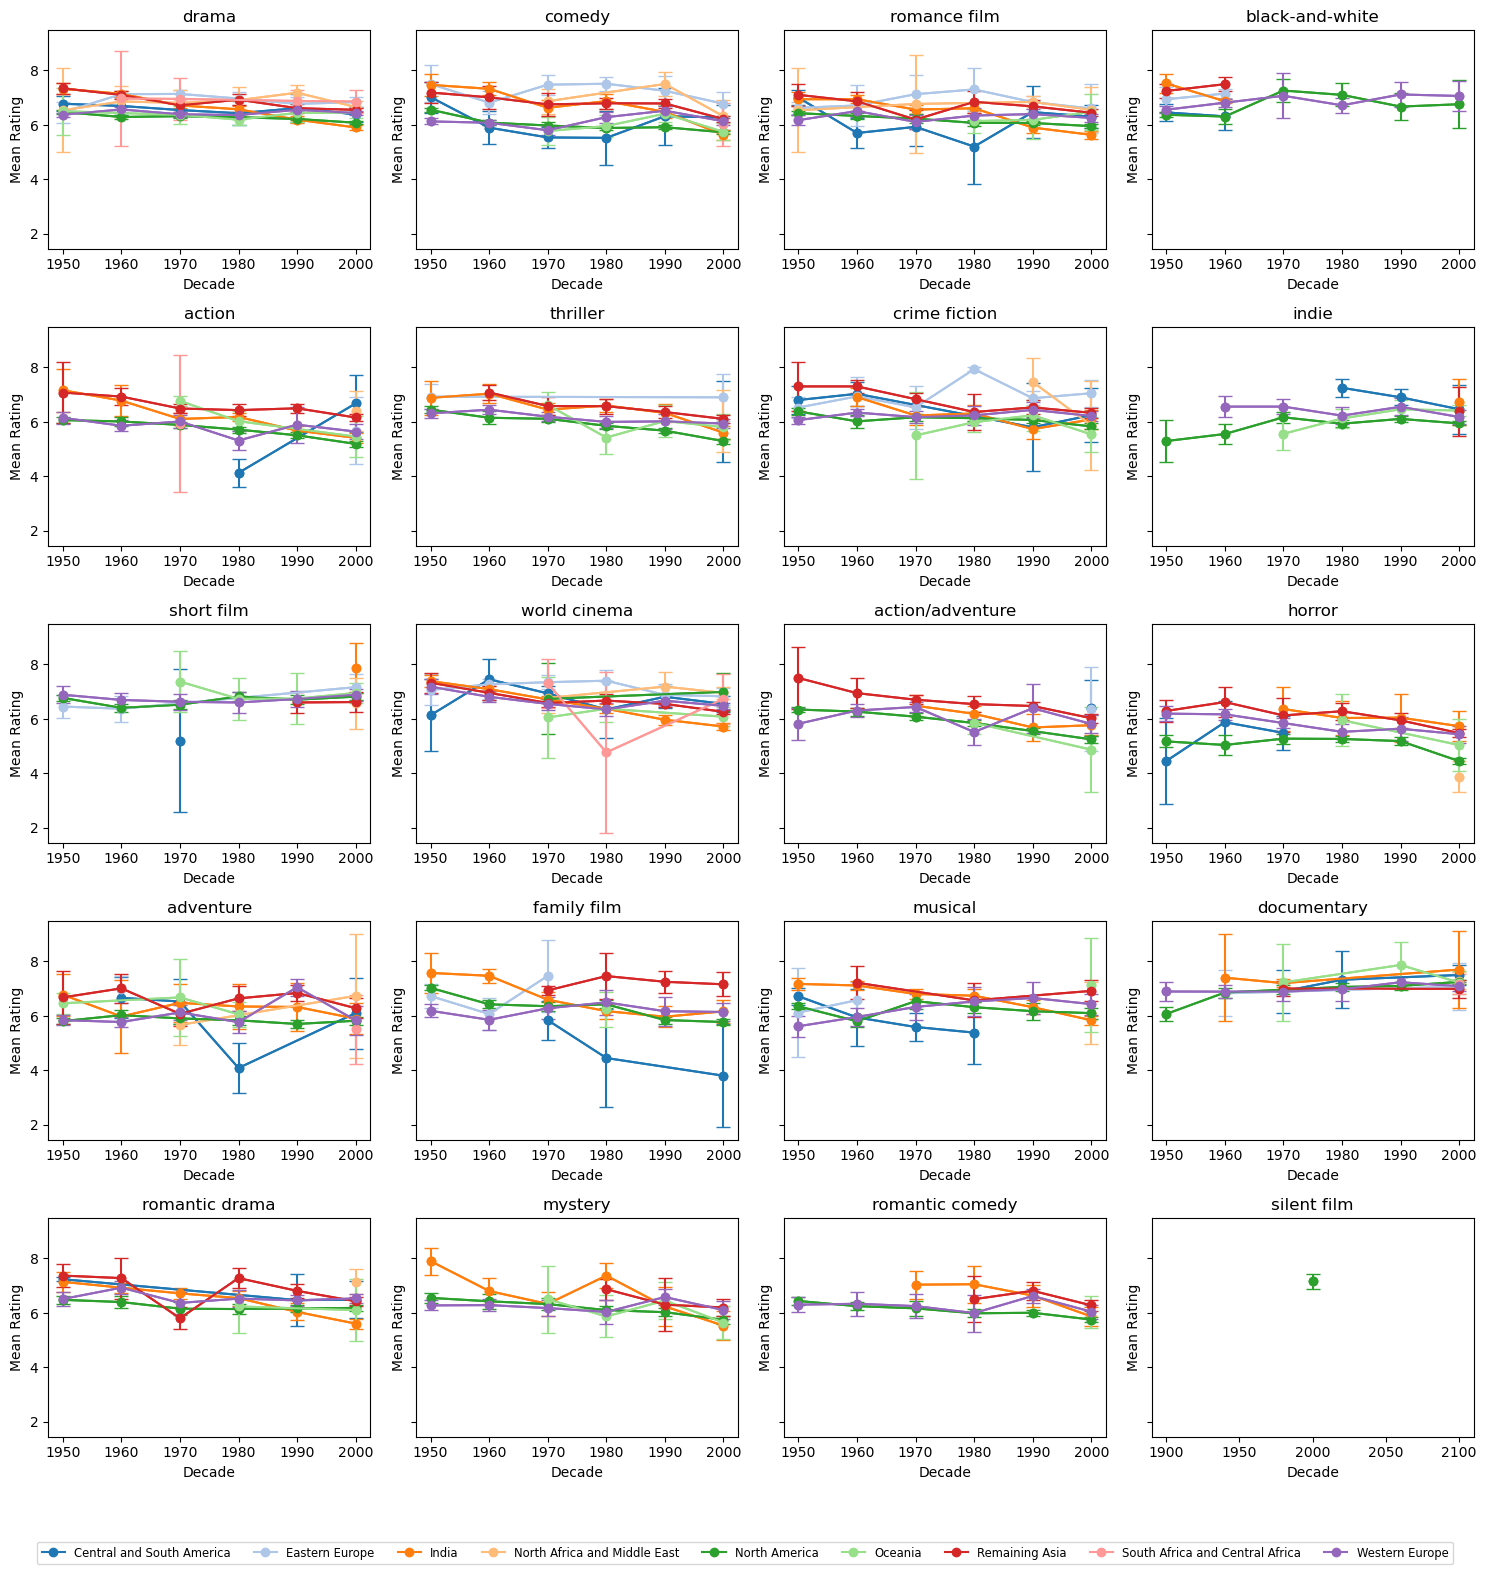

In [97]:
# The movies must be 'binned' into the decade in which they were released
def categorize_decade(release_date):
    if 1950 <= release_date < 1960:
        return '1950'
    elif 1960 <= release_date < 1970:
        return '1960'
    elif 1970 <= release_date < 1980:
        return '1970'
    elif 1980 <= release_date < 1990:
        return '1980'
    elif 1990 <= release_date < 2000:
        return '1990'
    elif 2000 <= release_date < 2010:
        return '2000'
    else:
        return None

# Defining the decades of interest
decades = ["1950", "1960", "1970", "1980", "1990", "2000"]

# A copy dataframe with blank movie(s) for the missing genre(s) of any geographic region in any deacde is required, to ensure no errors when plotting below
df_movies_tmdb_ratings_region_decade_filled = df_movies_tmdb_ratings_decades.copy()
for genre in top_20_genres_list:
    genre_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["genres"] == genre]
    for region in regions:
        genre_region_df = genre_df[genre_df["region"] == region]
        regions_with_genre_decade = genre_region_df["decade"].unique()
        regions_with_genre_decade = regions_with_genre_decade.tolist()
        if len(regions_with_genre_decade) < 6:
            for i in decades:
                if i not in regions_with_genre_decade:
                    new_row = {"region": region, "genres": genre, "averageRating": 0.0, "decade": i}
                    df_movies_tmdb_ratings_region_decade_filled = pd.concat([df_movies_tmdb_ratings_region_decade_filled, pd.DataFrame([new_row])], ignore_index=True)

# Dictionaries are required to store the mean ratings and confidence intervals of movies per region per genre over decades, from the 50's onwards
mean_ratings = {}
confidence_intervals = {}

# Looping through each genre to calculate the mean rating and CI per genre of film per region per decade
for genre in top_20_genres_list:
    genre_df = df_movies_tmdb_ratings_region_decade_filled[df_movies_tmdb_ratings_region_decade_filled["genres"] == genre]

    # Grouping by region and calculate mean ratings and stderr; here, the mean ratings per genre per decade in a given region are not rounded to the nearest 0.5
    region_mean_ratings = genre_df.groupby(["region", "decade"])

    region_mean_ratings_size = region_mean_ratings.size().sort_index()
    region_mean_ratings_regions_average = region_mean_ratings.mean("averageRating").sort_index()
    region_mean_ratings_regions_std = region_mean_ratings["averageRating"].std().sort_index()  
    region_mean_ratings_regions_stderr = region_mean_ratings_regions_std / np.sqrt(region_mean_ratings_size) 

    # Storing the mean ratings and confidence intervals for the region in the genre across decades
    region_means = np.zeros((9, 6))
    region_CI = np.zeros((9, 6))

    for i, region in enumerate(model_groupings):
        # To ensure validity of results, must ensure a given region and decade grouping for a given genre has at least 3 movies for their associated statistics to be reported
        for j, decade in enumerate(decades):
            if region_mean_ratings_size.loc[(region, decade)]<3:
                region_means[i][j] = 0.0
                region_CI[i][j] = 0.0
            else:
                region_means[i][j] = region_mean_ratings_regions_average.loc[(region, decade), "averageRating"]
                region_CI[i][j] = region_mean_ratings_regions_stderr.loc[(region, decade)] * 1.96

    # Appending the results to the dictionaries
    mean_ratings[genre] = region_means
    confidence_intervals[genre] = region_CI

# Defining the subplots, with one per genre
fig, axes = plt.subplots(5, 4, figsize=(15, 15), sharey=True)
axes = axes.flatten()

# Creating the subplot per genre of their mean ratings for the regions over the six decades considered
for i, genre_name in enumerate(mean_ratings.keys()):
    ax = axes[i]

    # Each region is stored as a row in the mean and confidence interval dictionaries and must have their mean ratings and CI per decade paired and plotted
    for j, (mean, stderr) in enumerate(zip(mean_ratings[genre_name], confidence_intervals[genre_name])):

        # As some means were made to be 0.0 if under three movies were given for that genre in that decade per region, these datapoints must not be plotted
        mask = np.array(mean) != 0
        filtered_means = np.array(mean)[mask]
        filtered_stderrs = np.array(stderr)[mask]

        # The mask must be applied to the decades (x-values) over which the mean ratings are being plotted to ensure the correct rating is placed at the correct decade
        filtered_decades = np.array(decades)[mask]

        # The visualization of regional mean ratings over decades per genre requires numerical forms of the decade list previously made
        decade_map = {}
        for i in decades:
            decade_map[i] = int(i)
        filtered_decades_as_int = []
        for i in filtered_decades:
            filtered_decades_as_int.append(decade_map[i])

        # To ensure the subfigure's ratings are plotted chronologically, the decades of a region with a mean rating reported must be sorted
        sorted_indices = np.argsort(filtered_decades_as_int)

        # The saved indeces of the decades to ensure they're chronologically ordered must be used to sort the regional mean ratings and associated CI
        filtered_decades = np.array(filtered_decades_as_int)[sorted_indices]
        filtered_means = filtered_means[sorted_indices]
        filtered_stderrs = filtered_stderrs[sorted_indices]
        
        # Defining the given genres color for plotting a line plot with error bars for every region's mean rating over the six decades in a given genre
        color = colors[j]
        ax.errorbar(filtered_decades, filtered_means, yerr=filtered_stderrs, label=model_groupings[j], capsize=5, marker='o', color=color)
        ax.plot(filtered_decades, filtered_means, marker='o', color=color)

    ax.set_title(genre_name)
    ax.set_xlabel('Decade')
    ax.set_ylabel('Mean Rating')

plt.tight_layout()
fig.legend(labels=model_groupings, loc='lower center', ncol=9, bbox_to_anchor=(0.5, -0.05), fontsize='small')
plt.show()

In [98]:
# To confirm the North American top five genre ratings are statistically different than the other regions, a t-test between each 
# genre's mean ratings between each region and North America was initially planned to be used

# As there are some movies that appear in more than one continent for production, then we have to consider that we are in a situation 
# where our samples are not entirely independent, which is a requirement for using a t-test; so, a linear-mixed model (LMM) is used

# The LMM determines for each genre which continent has a statistically signficant impact on movies in that genre's mean rating

# An LMM model can be applied as mean ratings we claim above to be normally distributed

# As we aim to determine the effect of continent on a movies rating, the mean rating is the outcome and the continent the predictor; also, 
# movie title is used as the random effect on the LMM as some movies exist across different countries and therefore this dependency of some
# ratings across continents has to be accounted for, as defining title as a random variable means each movie title when appearing more than 
# once will be considered by the model as potentially having a higher/lower rating that isn't due to the continent where the movie is produced

# DRAMA
# A new dataframe is created that one-hot encodes each continent, except for North America, as North America will be considered the baseline 
# from which a given genre's ratings per continent are compared to
df_movies_top_genres_drama_LMM = pd.DataFrame().assign(title=df_movies_top_genres_drama['title'], 
                                                       mean_rating=df_movies_top_genres_drama['mean_rating'], 
                                                       continent = df_movies_top_genres_drama['continent'])
df_movies_top_genres_drama_LMM = pd.get_dummies(df_movies_top_genres_drama_LMM, columns=['continent'])
df_movies_top_genres_drama_LMM = df_movies_top_genres_drama_LMM.drop(['continent_North America'], axis=1)
df_movies_top_genres_drama_LMM = df_movies_top_genres_drama_LMM.rename(columns={'continent_South America': 'continent_South_America'})

# A LMM model is fit considering no interaction of continents for predicting movie ratings
model_drama = mixedlm("mean_rating ~ continent_Africa + continent_Asia + continent_Europe + continent_Oceania + continent_South_America", 
                df_movies_top_genres_drama_LMM, groups="title")
result_drama = model_drama.fit()
print("The Comparison Between Mean Drama Movie Ratings Across Continents")
print(result.summary())

# The identical code used for the drama LMM is used for each of the remaining top five genres; ChatGPT helped copy and paste this for me

# COMEDY
df_movies_top_genres_comedy_LMM = pd.DataFrame().assign(title=df_movies_top_genres_comedy['title'], 
                                                        mean_rating=df_movies_top_genres_comedy['mean_rating'], 
                                                        continent=df_movies_top_genres_comedy['continent'])

df_movies_top_genres_comedy_LMM = pd.get_dummies(df_movies_top_genres_comedy_LMM, columns=['continent'])
df_movies_top_genres_comedy_LMM = df_movies_top_genres_comedy_LMM.drop(['continent_North America'], axis=1)
df_movies_top_genres_comedy_LMM = df_movies_top_genres_comedy_LMM.rename(columns={'continent_South America': 'continent_South_America'})

model_comedy = mixedlm("mean_rating ~ continent_Africa + continent_Asia + continent_Europe + continent_Oceania + continent_South_America", 
                df_movies_top_genres_comedy_LMM, groups="title")

result_comedy = model_comedy.fit()
print("The Comparison Between Mean Comedy Movie Ratings Across Continents")
print(result_comedy.summary())

# THRILLER
df_movies_top_genres_thriller_LMM = pd.DataFrame().assign(title=df_movies_top_genres_thriller['title'], 
                                                          mean_rating=df_movies_top_genres_thriller['mean_rating'], 
                                                          continent=df_movies_top_genres_thriller['continent'])

df_movies_top_genres_thriller_LMM = pd.get_dummies(df_movies_top_genres_thriller_LMM, columns=['continent'])
df_movies_top_genres_thriller_LMM = df_movies_top_genres_thriller_LMM.drop(['continent_North America'], axis=1)
df_movies_top_genres_thriller_LMM = df_movies_top_genres_thriller_LMM.rename(columns={'continent_South America': 'continent_South_America'})

model_thriller = mixedlm("mean_rating ~ continent_Africa + continent_Asia + continent_Europe + continent_Oceania + continent_South_America", 
                    df_movies_top_genres_thriller_LMM, groups="title")

result_thriller = model_thriller.fit()
print("The Comparison Between Mean Thriller Movie Ratings Across Continents")
print(result_thriller.summary())

# ROMANCE
df_movies_top_genres_romance_LMM = pd.DataFrame().assign(title=df_movies_top_genres_romance['title'], 
                                                         mean_rating=df_movies_top_genres_romance['mean_rating'], 
                                                         continent=df_movies_top_genres_romance['continent'])

df_movies_top_genres_romance_LMM = pd.get_dummies(df_movies_top_genres_romance_LMM, columns=['continent'])
df_movies_top_genres_romance_LMM = df_movies_top_genres_romance_LMM.drop(['continent_North America'], axis=1)
df_movies_top_genres_romance_LMM = df_movies_top_genres_romance_LMM.rename(columns={'continent_South America': 'continent_South_America'})

model_romance = mixedlm("mean_rating ~ continent_Africa + continent_Asia + continent_Europe + continent_Oceania + continent_South_America", 
                    df_movies_top_genres_romance_LMM, 
                    groups="title")

result_romance = model_romance.fit()
print("The Comparison Between Mean Romance Movie Ratings Across Continents")
print(result_romance.summary())

# WORLD CINEMA
df_movies_top_genres_world_cinema_LMM = pd.DataFrame().assign(title=df_movies_top_genres_world_cinema['title'], 
                                                              mean_rating=df_movies_top_genres_world_cinema['mean_rating'], 
                                                              continent=df_movies_top_genres_world_cinema['continent'])

df_movies_top_genres_world_cinema_LMM = pd.get_dummies(df_movies_top_genres_world_cinema_LMM, columns=['continent'])
df_movies_top_genres_world_cinema_LMM = df_movies_top_genres_world_cinema_LMM.drop(['continent_North America'], axis=1)
df_movies_top_genres_world_cinema_LMM = df_movies_top_genres_world_cinema_LMM.rename(columns={'continent_South America': 'continent_South_America'})

model_world_cinema = mixedlm("mean_rating ~ continent_Africa + continent_Asia + continent_Europe + continent_Oceania + continent_South_America", 
                             df_movies_top_genres_world_cinema_LMM, groups="title")

result_world_cinema = model_world_cinema.fit()
print("The Comparison Between Mean World Cinema Movie Ratings Across Continents")
print(result_world_cinema.summary())


NameError: name 'df_movies_top_genres_drama' is not defined

Using North American produced films as the baseline, the effect of the continent of production on the top five genres of films' mean ratings can be further analyzed and used to complement the produced bar plots above. 

A drama film listed with Europe or Asia as their continent has a statistically significant impact on their mean ratings. A 0.054 and a 0.052 increase in a drama movies' mean rating is considered if a given movie was alternatively produced out of Europe or Asia, respectively, rather than in North America.

A comedy film listed with Europe, Asia, or South America as their continent has a statistically significant impact on their mean ratings. A 0.125, 0.142, and a 0.124 increase in a comedy movies' mean rating is considered if a given movie was alternatively produced out of Europe, Asia, or South America, respectively, rather than in North America.

A thriller film listed with Europe or Asia as their continent has a statistically significant impact on their mean ratings. A 0.064 and a 0.071 increase in a thriller movies' mean rating is considered if a given movie was alternatively produced out of Europe or Asia, respectively, rather than in North America.

A romance film listed with Europe as their continent has a statistically significant impact on their mean ratings. A 0.050 increase in a romance movies' mean rating is considered if a given movie was alternatively produced out of Europe rather than in North America.

A world cinema film listed with Europe as their continent has a statistically significant impact on their mean ratings. A 0.062 increase in a world cinema movies' mean rating is considered if a given movie was alternatively produced out of Europe rather than in North America.

Note that these observations match those for the bar plots above: for drama films, North America significantly differs in mean rating from Europe and Asia, for comedy films North America significantly differs in mean ratings from Europe, Asia, and South America, for thriller films North America significantly differs in mean ratings from Europe and Asia (even though we expected also Africa to have a statistically significant impact on thriller movie ratings given the confidence interval for the mean rating of African thrillers doesn't overlap with any other countries except for Oceania), for romance films North America significantly differs in mean ratings from Europe, and for world cinema films North America differs in mean ratings from Europe.